## Step0~3 통합본

In [3]:
getwd()

[1] "/home/sysadm/Desktop/pogba_backup2/0_Gil_Prediction/02_code/SEIR/R/220614"

In [5]:
package_version(R.version)

[1] ‘4.1.1’

### Step0

Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

Rows: 1254 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): 연령, date
dbl (8): 구분, 차수, 화이자, AZ-AZ, AZ-Pf(2차만), M-P(2차만), 얀센, 모더나

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Coercing numeric to date G9959 / R9959C7”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Coercing numeric to date G11317 / R11317C7”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Coercing numeric to date G13432 / R13432C7”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Coercing numeric to date G35713 / R35713C7”
Warn

ERROR: Error in `$<-.data.frame`(`*tmp*`, Wild_type.true, value = numeric(0)): replacement has 0 rows, data has 213


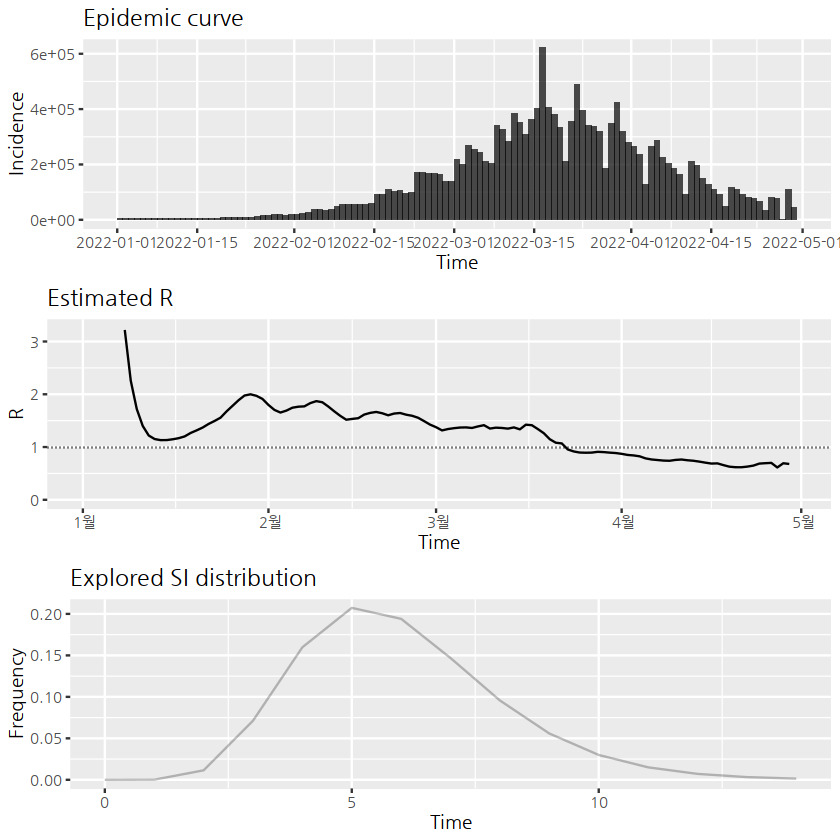

In [4]:
library(EpiEstim)
library(ggplot2)
library(tidyverse)
require(data.table)
require(deSolve)
library(gridExtra)
library(gridGraphics)
require(ggplot2)
library(dplyr)
library(lubridate)
require("sfsmisc")
library(scales)
library(gcookbook)
library(readxl)
library(readr)
# library(summarytools)
library(incidence)
library(tidyr)

# setwd("D://My Drive//2021_Korea SIR//Data")

lastdate<-545 ## by 2023

######################################Incidence data#################################################################
df_new<-read.csv("../../../../01_data/SEIR/owid-covid-data_0509.csv")

df<-df_new
df1<-df[c("date","location","new_cases","new_deaths", "new_tests", "people_vaccinated","people_fully_vaccinated")]
colnames(df1)[2]<-"state"
colnames(df1)[3]<-"cases"
colnames(df1)[4]<-"deaths"
df1$date =as.Date(df1$date, format="%Y-%m-%d")

df_kr<-df1%>% filter(state=="South Korea")
df_kr1<-df_kr[df_kr$date>="2022-01-01" & df_kr$date <"2022-04-30",]

cases<-df_kr1[c(1,3)]
colnames(cases)[2]<-"I"
colnames(cases)[1]<-"dates"

EL <- rep(0, times = 16)
ER <- rep(1, times = 16)
SL <- c(4,3,2,2,2,2,4,4,3,4,5,4,8,3,5,4)-1
SR <- c(8,4,4,5,9,4,6,5,4,5,6,5,9, 4,6,5)-1
type <- rep(0, times = 16)
df<-data.frame(EL, ER, SL, SR, type)

si<-c(0.05, 0.12, 0.18, 0.17, 0.16, 0.08, 0.05, 0.11, 0.04, 0.02, 0.01, 0.01)

Covid2021<-list("incidence" = cases, "si_distr" =si, "si_data" = df )
# head(Covid2021$incidence)
# Covid2021$si_distr
# head(Covid2021$si_data)


# plot(as.incidence(Covid2021$incidence$I, dates = Covid2021$incidence$dates))
# 
 incidence<-as.data.frame(Covid2021$incidence)
 incidence$dates =as.Date(incidence$dates, format="%Y-%m-%d")
 incidence1<-subset(incidence, dates >= "2022-01-01")
 incidence1$time <- 1:nrow(incidence1)


 
##Estimating R on sliding weekly windows, with a parametric serial interval
res_parametric_si <- estimate_R(Covid2021$incidence, 
                                method="parametric_si",
                                config = make_config(list(
                                  mean_si = 6, 
                                  std_si = 2))
)

#head(res_parametric_si$R)
plot(res_parametric_si, legend = FALSE)

Rt<-as.data.frame(res_parametric_si$R)
colnames(Rt)[3]<-"average_Rt"
Rt1<-subset(Rt, Rt$t_start > 24)
Rt1$time <- 1:nrow(Rt1)
aver_Rt<-mean(Rt1$average_Rt)
beta<-Rt1$average_Rt/14
#plot(aver_Rt)

# min(Rt)
# max(Rt)
# summary(Rt$average_Rt)
# 
# plot(df_kr$date, df_kr$new_tests)

######################################vaccination & variants data#################################################################
read_csv("../../../../01_data/SEIR/vaxx_1123_1.csv")->vac_prop


colnames(vac_prop) <-  c("time",    "age",    "dose",    "date",    "pfizer",    "JJ",    "moderna",    "AZ",    "AZPF")
vac_prop$age1 = ifelse(grepl("17", vac_prop$age), "1",
                       ifelse( grepl("18-19", vac_prop$age),"1",
                               ifelse(grepl("20-29", vac_prop$age),"2",
                               ifelse(grepl("30-39", vac_prop$age), "2",
                                      ifelse(grepl("40-49", vac_prop$age), "3",
                                             ifelse( grepl("50-59", vac_prop$age),"3",
                                                     ifelse(  grepl("60-64", vac_prop$age), "4",
                                                              ifelse(grepl("65-69", vac_prop$age), "4",
                                                                     ifelse( grepl("70-74", vac_prop$age), "4",
                                                                             ifelse(grepl("75-79", vac_prop$age), "4",
                                                                                    ifelse(grepl("80", vac_prop$age), "4",
                                                                                           NA))))))))))) ##case_when



vac_prop$date =as.Date(vac_prop$date , format="%m/%d/%Y")
popsize<-c(8907071, 13796133, 16695543, 11870436) ##0-19; 20-39; 40-59; 60+


vac_prop <- vac_prop %>% dplyr::select("time",    "age1",    "dose",    "date",    "pfizer",    "JJ",    "moderna",    "AZ",    "AZPF") %>%
        mutate(mRNA = pfizer + moderna) %>%
        mutate(week = strftime(date, "%V")) 

vac_prop <- vac_prop %>%
        dplyr::select(week, date, age1, dose, mRNA, AZ, JJ, AZPF) %>%
        mutate(dose = case_when (dose == 1 ~ c("dose1"),dose == 2 ~ c("dose2"), dose == 3 ~ c("dose3")))

# variants<-read_excel("variants_1123_3.xlsx") ##old data
variants<-read_excel("../../../../11_data/SEIR/variants_1005_1.xlsx") ##old data


variants1 <- variants[c(4, 8, 16)]
colnames(variants1) <- c("age",  "date", "virus")
# freq(variants1$virus)
# summary(variants1$date)

vac_prop$date<-as.Date(vac_prop$date)
variants1$date<-as.Date(variants1$date)

variants2<-variants1 %>% filter(date > "2021-03-05" & date < "2021-11-20") %>%
        #filter(!is.na(virus)) %>% filter(virus!=c("분석불가")) %>% 
        mutate(virus=case_when(virus==c("-") ~ c("Wild_type"),virus == NA ~ c("Wild_type"),
                               virus==c("alpha") ~ c("alpha"),
                               virus==c("delta") ~ c("delta"),
                               TRUE ~ c("etc"))) 

a<-data.frame(unclass(table(variants2$date,variants2$virus)))
a$Wild_type.true<-round(a$Wild_type*0.3) #70% are missing testing data (to be confirmed)
a$total<-rowSums(a[, c(1:4)])
#a$total<-colSums(a)
a$Delta.p<-round(a$delta/a$total,2)

aa <- cbind(rownames(a), data.frame(a, row.names=NULL))
names(aa)[1]<-"date"
aa$date<-as.Date(aa$date)
aaa<-aa %>% dplyr ::select(date, Delta.p)  
aaa$week= strftime(aaa$date, "%V")

aaa1<-aaa%>% 
        group_by(week)  %>%
        summarize(Delta.wp=max(Delta.p))

vac_prop1<-merge(vac_prop, aaa1, by=c("week"), all.x=TRUE)

ve_AZ1=0.5; ve_AZ2=0.77; ve_AZ3=0.8; ve_AZ1_delta=0.3; ve_AZ2_delta =0.66; ve_AZ3_delta=0.7
ve_JJ = 0.5; ve_JJ_delta = 0.3; 

ve_mRNA1 = 0.5; ve_mRNA2=0.95; ve_mRNA3=0.98
ve_mRNA1_delta=0.35; ve_mRNA2_delta=0.88; ve_mRNA3_delta=0.9

ve_mRNA_v <- c(ve_mRNA1, ve_mRNA2, ve_mRNA3)
ve_mRNA_delta_v<- c(ve_mRNA1_delta, ve_mRNA2_delta, ve_mRNA3_delta)

ve_AZ_v <- c(ve_AZ1, ve_AZ2, ve_AZ3)
ve_AZ_delta_v<- c(ve_AZ1_delta, ve_AZ2_delta, ve_AZ3_delta)

ve_JJ_v <- c(ve_JJ)
ve_JJ_delta_v<- c(ve_JJ_delta)

vac_prop3<-vac_prop1 %>%  
        ungroup()%>%
        mutate(age1=as.numeric(age1))%>%
        mutate(week=as.numeric(week))%>%
        mutate(totalpop=popsize[age1])%>%
        group_by(week, dose, age1) %>% 
        summarise (mRNA_p = sum (mRNA), AZ_p =sum(AZ), JJ_p=sum(JJ), AZPF_p=sum(AZPF), Delta.wp = first(Delta.wp), .groups="drop") %>%
        mutate(dose=factor(dose)) %>%
        mutate(ve_mRNA_w=(ve_mRNA_v[dose]*(1-Delta.wp)+ve_mRNA_delta_v[dose]*Delta.wp),
               mRNA_result = mRNA_p * ve_mRNA_w)%>%
        mutate(ve_AZ_w=(ve_AZ_v[dose]*(1-Delta.wp)+ve_AZ_delta_v[dose]*Delta.wp),
               AZ_result = AZ_p * ve_AZ_w)%>%
        mutate(ve_JJ_w=(ve_JJ_v*(1-Delta.wp)+ve_JJ_delta_v*Delta.wp),
               JJ_result = JJ_p * ve_JJ_w)%>%
        mutate(ve_AZPF_w=(ve_AZ_v[dose]*(1-Delta.wp)+ve_mRNA_delta_v[dose]*Delta.wp),
               AZPF_result = AZPF_p * ve_AZPF_w)

vac_prop4 <- vac_prop3 %>% 
        group_by(week, age1) %>%
        summarise (mRNA_p=sum(mRNA_p),
                   AZ_p=sum(AZ_p),
                   JJ_p=sum(JJ_p),
                   AZPF_p=sum(AZPF_p),
                   ve_mRNA_w = sum(ve_mRNA_w),
                   ve_AZ_w = sum(ve_AZ_w),
                   ve_JJ_w = sum(ve_JJ_w),
                   ve_AZPF_w = sum(ve_AZPF_w),
                   mRNA_result=sum(mRNA_result),
                   AZ_result=sum(AZ_result),
                   JJ_result=sum(JJ_result),
                   AZPF_result=sum(AZPF_result),
                   .groups="drop") %>%
        mutate(tot_result = rowSums(.[11:14])) 

vac_prop5 <- vac_prop4 %>% dplyr ::select(week, age1, tot_result)
vac_prop6<- round(spread(vac_prop5, key=week, value=tot_result))
vac_prop6 <- vac_prop6[,-1 ] 


##vac uptake from July-Oct first week
vac_prop7<-subset(vac_prop6[, c(18:38)])

vac_prop8<-vac_prop7/7  ## divide by 7 in order to convert to daily vaccination number

vac_prop8<-as.data.frame(vac_prop8,use.names=FALSE)
vac_prop8<-as.matrix(vac_prop8)
colnames(vac_prop8)<- NULL

aa1<-as.vector(vac_prop8[1,1:21])
aa2<-as.vector(vac_prop8[2,1:21])
aa3<-as.vector(vac_prop8[3,1:21])
aa4<-as.vector(vac_prop8[4,1:21])

age.vac<-matrix(NA, nrow=4, ncol=280) #30*7

for(i in 0:29){
        age.vac[1,(i*7+1):(i*7+7)]<-rep(aa1[i+1], each =7)
        age.vac[2,(i*7+1):(i*7+7)]<-rep(aa2[i+1], each =7)
        age.vac[3,(i*7+1):(i*7+7)]<-rep(aa3[i+1], each =7)
        age.vac[4,(i*7+1):(i*7+7)]<-rep(aa4[i+1], each =7)
}

age.vac[is.na(age.vac)] <- 0

age.vac1<-matrix(NA, nrow=4, ncol=lastdate)
age.vac1[1,]<-round(mean(age.vac[1,1:200]))
age.vac1[2,]<-round(mean(age.vac[2,1:200]))
age.vac1[3,]<-round(mean(age.vac[3,1:200]))
age.vac1[4,]<-round(mean(age.vac[4,1:200]))




In [3]:
install.packages("remotes")        # Using devtools is also possible
library(remotes)
install_github("rapporter/pander") # Strongly recommended
install_github("dcomtois/summarytools", build_vignettes = TRUE)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done




Rcpp   (1.0.7  -> 1.0.8.3) [CRAN]
digest (0.6.28 -> 0.6.29 ) [CRAN]


Installing 2 packages: Rcpp, digest

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Running `R CMD build`...



* checking for file ‘/tmp/Rtmpo96xKT/remotes410458a835b3/Rapporter-pander-7d5d9dd/DESCRIPTION’ ... OK
* preparing ‘pander’:
* checking DESCRIPTION meta-information ... OK
* cleaning src
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘pander_0.6.6.tar.gz’


rlang       (0.4.12 -> 1.0.2 ) [CRAN]
magrittr    (2.0.1  -> 2.0.3 ) [CRAN]
fansi       (0.4.2  -> 1.0.3 ) [CRAN]
crayon      (1.4.2  -> 1.5.1 ) [CRAN]
cli         (3.1.0  -> 3.3.0 ) [CRAN]
pillar      (1.6.4  -> 1.7.0 ) [CRAN]
vctrs       (0.3.8  -> 0.4.1 ) [CRAN]
tidyselect  (1.1.1  -> 1.1.2 ) [CRAN]
tibble      (3.1.5  -> 3.1.7 ) [CRAN]
glue        (1.4.2  -> 1.6.2 ) [CRAN]
generics    (0.1.1  -> 0.1.2 ) [CRAN]
stringi     (1.7.5  -> 1.7.6 ) [CRAN]
plyr        (1.8.6  -> 1.8.7 ) [CRAN]
cpp11       (0.4.1  -> 0.4.2 ) [CRAN]
dplyr       (1.0.7  -> 1.0.9 ) [CRAN]
backports   (1.3.0  -> 1.4.1 ) [CRAN]
tidyr       (1.1.4  -> 1.2.0 ) [CRAN]
matrixStats (0.61.0 -> 0.62.0) [CRAN]
magick      (NA     -> 2.7.3 ) [CRAN]


Installing 19 packages: rlang, magrittr, fansi, crayon, cli, pillar, vctrs, tidyselect, tibble, glue, generics, stringi, plyr, cpp11, dplyr, backports, tidyr, matrixStats, magick

Warning message in i.p(...):
“installation of package ‘magick’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Running `R CMD build`...



* checking for file ‘/tmp/Rtmpo96xKT/remotes41041f00be15/dcomtois-summarytools-7df2bef/DESCRIPTION’ ... OK
* preparing ‘summarytools’:
* checking DESCRIPTION meta-information ... OK
* installing the package to build vignettes
      -----------------------------------
ERROR: dependency ‘magick’ is not available for package ‘summarytools’
* removing ‘/tmp/RtmpLiKq86/Rinst7ad7574ca093/summarytools’
      -----------------------------------
ERROR: package installation failed
STDOUT:
* checking for file ‘/tmp/Rtmpo96xKT/remotes41041f00be15/dcomtois-summarytools-7df2bef/DESCRIPTION’ ... OK
* preparing ‘summarytools’:
* checking DESCRIPTION meta-information ... OK
* installing the package to build vignettes
      -----------------------------------
ERROR: dependency ‘magick’ is not available for package ‘summarytools’
* removing ‘/tmp/RtmpLiKq86/Rinst7ad7574ca093/summarytools’
      -----------------------------------
ERROR: package installation failed
STDERR:



ERROR: Error: Failed to install 'summarytools' from GitHub:
  Failed to `R CMD build` package, try `build = FALSE`.


In [2]:
install.packages("summarytools")

‘magick’(들)을 또한 설치합니다.


Warning message in install.packages("summarytools"):
“installation of package ‘magick’ had non-zero exit status”
Warning message in install.packages("summarytools"):
“installation of package ‘summarytools’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [4]:
find.package('summarytools')

ERROR: Error in find.package("summarytools"): ‘summarytools’이라고 불리는 패키지가 없습니다


In [3]:
install.packages("summarytools", repos='http://cran.us.r-project.org')

‘magick’(들)을 또한 설치합니다.


Warning message in install.packages("summarytools", repos = "http://cran.us.r-project.org"):
“installation of package ‘magick’ had non-zero exit status”
Warning message in install.packages("summarytools", repos = "http://cran.us.r-project.org"):
“installation of package ‘summarytools’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [5]:
install.packages("summarytools")

‘magick’(들)을 또한 설치합니다.


Warning message in install.packages("summarytools"):
“installation of package ‘magick’ had non-zero exit status”
Warning message in install.packages("summarytools"):
“installation of package ‘summarytools’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [5]:

sir_CEA_ud2 <- function(t,X,parms){
  # 
  # for (i in 1:length(X)) {
  #   if (X[i]< 0) {
  #     X[i]<- 0
  #   }}
  
  ncompartment=20
  nage=length(X)/ncompartment
  
  U =(X[1:nage])
  V =(X[(nage+1):(2*nage)])
  E =(X[(2*nage+1):(3*nage)])
  A =(X[(3*nage+1):(4*nage)])
  TP_ud=(X[(4*nage+1):(5*nage)])
  TP_noud=(X[(5*nage+1):(6*nage)])
  S_ud =(X[(6*nage+1):(7*nage)])
  S_noud = (X[(7*nage+1):(8*nage)])
  H_ud =(X[(8*nage+1):(9*nage)])
  H_noud = (X[(9*nage+1):(10*nage)])
  R_ud =(X[(10*nage+1):(11*nage)])
  R_noud = (X[(11*nage+1):(12*nage)])
  D_ud =(X[(12*nage+1):(13*nage)])
  D_noud = (X[(13*nage+1):(14*nage)])
  TP_ud.I =(X[(14*nage+1):(15*nage)])
  TP_noud.I =(X[(15*nage+1):(16*nage)])
  S.I_ud =(X[(16*nage+1):(17*nage)])
  S.I_noud= (X[(17*nage+1):(18*nage)])
  H.I_ud=(X[(18*nage+1):(19*nage)])
  H.I_noud= (X[(19*nage+1):(20*nage)])
  
  with(as.list(c(parms, X)), {
    
    # if (t==1){
    #   print(testing)
    #   print(vaccinating)
    # }
    # 
    # for (i in 1:length(X)) {
    #   if (X[i]< 0) {
    #     X[i]<- 0
    #   }}
    
    vaccination <- matrix(vac1(t, U, age.vac1), nrow=4, ncol=lastdate, byrow=F)
    #waining1 <- parms$wan*(V)
    waining2 <- parms$wan*(R_ud)
    waining3 <- parms$wan*(R_noud)
    #vaccination <- matrix(vac1(t), nrow=4, ncol=lastdate, byrow=T)*U
    infection1 <- matrix(contactpattern(t, aver_Rt), nrow=4, ncol=lastdate, byrow=T)* as.vector(((U*(C))%*%(A/(U+A+V+E))))
    infection2 <- matrix(contactpattern(t, aver_Rt), nrow=4, ncol=lastdate, byrow=T)* as.vector((V)*(A/(U+A+V+E)))
    #infection2 <- matrix(contactpattern(t, aver_Rt), nrow=4, ncol=lastdate, byrow=T)* as.vector((V*(C))%*%(A/(U+A+V+E)))
    incubation <- parms$theta*(E)
    testingrate <- matrix(tau2_1(t, tau2), nrow=4, ncol=lastdate, byrow=T)*Se*A
    screeningrate <- parms$tau1*(1-Sp)*(U)
    
    progression1 <-parms$sigma*(A)
    
    progression2 <-parms$sigma*(TP_ud)
    progression3 <-parms$sigma*(TP_noud)
    
    recovery1_ud <-parms$rho*(S_ud)
    recovery1_noud <-parms$rho*(S_noud)
    
    recovery2 <-parms$rho*(A)
    recovery3_ud <-parms$rho*(TP_ud)
    recovery3_noud <-parms$rho*(TP_noud)
    
    recovery4_ud <-parms$rho_h*(1-parms$delta )*H_ud
    recovery4_noud <-parms$rho_h*(1-parms$delta )*H_noud
    
    dead_ud <-parms$delta *(H_ud)
    dead_noud <-parms$delta *(H_noud)
    
    hospitalization_ud<-parms$adm_ud*S_ud
    hospitalization_noud<-parms$adm_noud*S_noud
    
    dUdt <- -infection1 - vaccination  +waining2 +waining3 #+waining1
    dVdt <- vaccination  - infection2 #-waining1
    dEdt <- infection1 - incubation + infection2
    dAdt <- incubation - testingrate - progression1 - recovery2
    dTP_uddt<- testingrate - recovery3_ud - progression2
    dTP_nouddt<- testingrate - recovery3_noud - progression3
    
    dS_uddt <- progression2 + progression1 - recovery1_ud - hospitalization_ud 
    dS_nouddt <- progression3 + progression1 - recovery1_noud - hospitalization_noud 
    
    dH_uddt <- hospitalization_ud - recovery4_ud - dead_ud
    dH_nouddt <- hospitalization_noud - recovery4_noud - dead_noud
    
    dR_uddt <- recovery1_ud+recovery2+recovery3_ud+recovery4_ud-waining2
    dR_nouddt <- recovery1_noud+recovery2+recovery3_noud+recovery4_noud-waining3
    
    dD_uddt <- dead_ud
    dD_nouddt <- dead_noud
    
    dTP_ud.Idt<- testingrate 
    dTP_noud.Idt<- testingrate 
    
    dS.I_uddt<- progression2 + progression1
    dS.I_nouddt<- progression3 + progression1
    
    dH.I_uddt<-hospitalization_ud
    dH.I_nouddt<-hospitalization_noud
    
    SEIR <- rbind(dUdt, dVdt, dEdt, dAdt, dTP_uddt,dTP_nouddt,dS_uddt,dS_nouddt, dH_uddt, dH_nouddt, dR_uddt,dR_nouddt, dD_uddt,dD_nouddt, dTP_ud.Idt,  dTP_noud.Idt, 
                  dS.I_uddt, dS.I_nouddt, dH.I_uddt, dH.I_nouddt)
    SEIR=as.data.frame(SEIR)
    
  })
}



In [6]:
age.vac1

ERROR: Error in eval(expr, envir, enclos): 객체 'age.vac1'를 찾을 수 없습니다


In [8]:
## input param


############################### Rt, Testing, vaccination time functions ##########################################################
t <- seq(1, lastdate, by=1) 

vr=0.5 #by vaccination rate: 0.8,1
vac1 <- function(t, U, age.vac1) {
  res <- (t >= 1 & t < 142) * age.vac1  +
    (t >= 142 & t < 180) * age.vac1*c(3,0.5,0.5,0.1) *vr+  ## by Dec 2021
    (t >= 180 & t < 360) * age.vac1*c(2,0.3,0.2,0.01) *vr + #0.25  ## by Jun 2022
    (t >= 360 & t < 540) *age.vac1*c(0,0,0,0) *vr ##0.1  ## by Dec 2022
  return(pmin(res, U))
}


test<-df_kr[c("date","new_tests")]
test1<-subset(test, test$date >= "2022-01-01")
aver_test<-mean(test1$new_tests, na.rm=TRUE)
tau2<-aver_test/5000000 ## assumed total asymptomatic population

tr=1 #by test rate: 1,0.8,1.2
tau2_1 <- function(t, tau2) (t >= 1 & t < 142) * mean(tau2) +
  (t >= 142 & t < lastdate) * mean(tau2)*tr

##transimissibility
contact=1
transimissibility=aver_Rt*1/14*(1/contact)
npi=0.5 #0.5 0.6 0.7
npi_d=150+90 ##NPI by Feb, Apr, and Jun 2022 210 240 270


contactpattern <- function(t, aver_Rt) (t >= 1 & t < 200) * aver_Rt*1/14*(1/contact)*2 + ##Rt1.1
  (t >= 200 & t < 300) * aver_Rt*1/14*(1/contact)*7 +
  (t >= 300 & t  < lastdate) * aver_Rt*1/14*(1/contact)*1 ##Transmiss ##Transmissibility increase 2/2.2/2.4


########################################Initial conditions ######################################################################
npop <- 51822000
f <- c(0.17, 0.27, 0.33, 0.23) # four age classes, with 0-19; 20-39; 40-59; 60+ in Korea 2021
nage <-  length(f)
N <-  npop*f      # number in each age class


Se<- 0.95   #sensitivity
Sp<-0.998
mu = c(0, 0, 0,0) # screening return per day
tau1 = c(0, 0, 0,0)
#tau2= c(0.01, 0.01 , 0.01)*1 # testing per day (0.3)/(1-(0.3))*sigma :: assuming 30% testing among asymptomatic pop
#beta = c(0.1, 0.12, 0.13)*1 # infectious contacts per capita per day
theta = c(0.35, 0.35, 0.35, 0.35)  # incubation per day
sigma = c(0.14, 0.2, 0.15, 0.12)
#sigma = c(0.00025, 0.0058, 0.029, 0.19) # progression per day
rho = c(1/14, 1/14, 1/14, 1/14) 
rho_h = c(1/14, 1/14, 1/14, 1/14) # recovery per day
delta = c(0.00004, 0.0001, 0.00098, 0.047)  # case fatality among symptomatic patients per day
#vac = c(0, 0.03, 0.031)*1 ## July 0.03
eff<-1
adm_ud=c(0.00002,0.00152,0.00739,0.07959)*c(1, eff, eff, eff)
adm_noud=c(0.00002,0.00152,0.00739,0.07959)*c(1, 1, 1, 1) ## 0.7 as mol and 0.16 as pax
wan=c(0,0.0001,0.0001,0.0001)

# adm_ud=c(0.00025,0.0058,0.029,0.19)*0.2*c(1, eff, eff, eff)
# adm_noud=c(0.00025,0.0058,0.029,0.19)*0.2*c(1, eff, eff, eff) ## 0.7 as mol and 0.16 as pax
ud_p=c(0.3,0.3,0.3,0.3)

values <- list (mu = matrix(mu,nrow=4, ncol=lastdate ),
                tau1= matrix(tau1,nrow=4, ncol=lastdate ),
                theta= matrix(theta,nrow=4, ncol=lastdate ),
                sigma= matrix(sigma,nrow=4, ncol=lastdate),
                rho= matrix(rho,nrow=4, ncol=lastdate ),
                rho_h= matrix(rho_h,nrow=4, ncol=lastdate ),
                delta= matrix(delta,nrow=4, ncol=lastdate ),
                adm_ud=matrix(adm_ud,nrow=4, ncol=lastdate ),
                adm_noud=matrix(adm_noud,nrow=4, ncol=lastdate ),
                ud_p=matrix(ud_p,nrow=4, ncol=lastdate ),
                wan=matrix(wan,nrow=4, ncol=lastdate ),
                age.vac1=age.vac1,
                aver_Rt=aver_Rt,
                tau2=tau2  
                )

C = matrix(0,nrow=nage,ncol=nage)
C[1,1] = 2.3  # number contacts per day kids make with kids
C[1,2] = 0.6  
C[1,3] = 0.5  # number contacts per day kids make with adults (all kids have an adult in the home)
C[1,4] = 0.1 

C[2,1] = 0.7  # number contacts per day adults make with kids (not all adults have kids)
C[2,2] = 1.9
C[2,3] = 1.0
C[2,4] = 0.1

C[3,1] = 0.9  # number contacts per day adults make with kids (not all adults have kids)
C[3,2] = 1.2 
C[3,3] = 1.5  # number contacts per day adults make with adults
C[3,4] = 0.2 

C[4,1] = 0.3  # number contacts per day adults make with kids (not all adults have kids)
C[4,2] = 0.4 
C[4,3] = 0.5  # number contacts per day adults make with adults
C[4,4] = 0.4 


#install.packages("rootSolve")
#library(rootSolve)


##https://cran.r-project.org/web/packages/LaplacesDemon/index.html

V=c(724, 1257656, 1360168, 7290718) #by end of June cumulative vaccine uptake ( 724 1257656 1360168 7290718)
E=c(1000, 2000, 2000, 2000)
A=c(1000, 2000, 2000, 2000)
TP_ud=c(100, 200, 400, 300)*ud_p
TP_noud=c(100, 200, 400, 300)*(1-ud_p)
S_ud=c(0, 200, 400, 300)*ud_p
S_noud=c(200, 200, 400, 300)*(1-ud_p)
H_ud=c(2, 4, 8, 6)*ud_p
H_noud=c(2, 4, 8, 6)*(1-ud_p)
R_ud=c(50000,50000, 50000, 100000)*ud_p 
R_noud=c(50000,50000, 50000, 100000)*(1-ud_p) ## total confirmed cases 450,000 
D_ud=c(0, 0, 500, 1000)*ud_p
D_noud=c(0, 0, 500, 1000)*(1-ud_p)

TP_ud.I=c(100, 1000, 1000, 1000)*ud_p 
TP_noud.I=c(100, 1000, 1000, 1000)*(1-ud_p)
S.I_ud=c(100, 1000, 1000, 1000)*ud_p
S.I_noud=c(100, 1000, 1000, 1000)*(1-ud_p)
H.I_ud=c(2, 20, 20, 20)*ud_p
H.I_noud=c(2, 20, 20, 20)*(1-ud_p)
U = N-E-A-V-R_ud-R_noud

pop.SI <- c(U = N-E-A-V-R_ud-R_noud, V=V, E=E, A=A ,TP_ud=TP_ud, TP_noud=TP_noud, S_ud=S_ud, S_noud=S_noud, H_ud=H_ud, H_noud=H_noud,  R_ud=R_ud, R_noud=R_noud, 
            D_ud=D_ud, D_noud=D_noud,  TP_ud.I=TP_ud.I, TP_noud.I=TP_noud.I, S.I_ud=S.I_ud, S.I_noud=S.I_noud, H.I_ud=H.I_ud, H.I_noud=H.I_noud)


############################################ ODE simulation ###################################################################
result=lsoda(
  y = pop.SI,               # Initial conditions for population
  times = t,                # Timepoints for evaluation
  func = sir_CEA_ud2,           # Function to evaluate
  parms = values            # Vector of parameters
  
)

result1<-result[,c(1:81)]
result2<-as.data.frame(result1)

result2$U<-result2$U1+result2$U2+result2$U3+result2$U4
result2$V<-result2$V1+result2$V2+result2$V3+result2$V4
result2$E<-result2$E1+result2$E2+result2$E3+result2$E4
result2$A<-result2$A1+result2$A2+result2$A3+result2$A4
result2$TP_ud<-result2$TP_ud1+result2$TP_ud2+result2$TP_ud3+result2$TP_ud4
result2$TP_noud<-result2$TP_noud1+result2$TP_noud2+result2$TP_noud3+result2$TP_noud4

result2$TP<-result2$TP_ud+result2$TP_noud

result2$S_ud<-result2$S_ud1+result2$S_ud2+result2$S_ud3+result2$S_ud4
result2$S_noud<-result2$S_noud1+result2$S_noud2+result2$S_noud3+result2$S_noud4

result2$S<-result2$S_ud+result2$S_noud

result2$H_ud<-result2$H_ud1+result2$H_ud2+result2$H_ud3+result2$H_ud4
result2$H_noud<-result2$H_noud1+result2$H_noud2+result2$H_noud3+result2$H_noud4

result2$H<-result2$H_ud+result2$H_noud

result2$R_ud<-result2$R_ud1+result2$R_ud2+result2$R_ud3+result2$R_ud4
result2$R_noud<-result2$R_noud1+result2$R_noud2+result2$R_noud3+result2$R_noud4

result2$D_ud<-result2$D_ud1+result2$D_ud2+result2$D_ud3+result2$D_ud4
result2$D_noud<-result2$D_noud1+result2$D_noud2+result2$D_noud3+result2$D_noud4

result2$TP_ud.I<-result2$TP_ud.I1+result2$TP_ud.I2+result2$TP_ud.I3+result2$TP_ud.I4
result2$TP_noud.I<-result2$TP_noud.I1+result2$TP_noud.I2+result2$TP_noud.I3+result2$TP_noud.I4

result2$TP.I<-result2$TP_ud.I+result2$TP_noud.I

result2$S.I_ud<-result2$S.I_ud1+result2$S.I_ud2+result2$S.I_ud3+result2$S.I_ud4

#result2$S.I_ud<-result2$S.I_ud2+result2$S.I_ud3+result2$S.I_ud4
result2$S.I_noud<-result2$S.I_noud1+result2$S.I_noud2+result2$S.I_noud3+result2$S.I_noud4

result2$S.I<-result2$S.I_ud+result2$S.I_noud

result2$H.I_ud<-result2$H.I_ud1+result2$H.I_ud2+result2$H.I_ud3+result2$H.I_ud4
result2$H.I_noud<-result2$H.I_noud1+result2$H.I_noud2+result2$H.I_noud3+result2$H.I_noud4
result2$H.I<-result2$H.I_ud+result2$H.I_noud

result2$TP_ud1.incidence <- c(100*0.3,diff(result2$TP_ud.I1))
result2$TP_ud2.incidence <- c(200*0.3,diff(result2$TP_ud.I2))
result2$TP_ud3.incidence <- c(400*0.3,diff(result2$TP_ud.I3))
result2$TP_ud4.incidence <- c(300*0.3,diff(result2$TP_ud.I4))
result2$TP_ud.incidence <- c(1000*0.3,diff(result2$TP_ud.I))

result2$TP_noud1.incidence <- c(100*0.7,diff(result2$TP_noud.I1))
result2$TP_noud2.incidence <- c(200*0.7,diff(result2$TP_noud.I2))
result2$TP_noud3.incidence <- c(400*0.7,diff(result2$TP_noud.I3))
result2$TP_noud4.incidence <- c(300*0.7,diff(result2$TP_noud.I4))
result2$TP_noud.incidence <- c(1000*0.7,diff(result2$TP_noud.I))

result2$TP.incidence<-result2$TP_ud.incidence+result2$TP_noud.incidence

result2$S_ud1.incidence <- c(100*0.3,diff(result2$S.I_ud1))
result2$S_ud2.incidence <- c(200*0.3,diff(result2$S.I_ud2))
result2$S_ud3.incidence <- c(400*0.3,diff(result2$S.I_ud3))
result2$S_ud4.incidence <- c(300*0.3,diff(result2$S.I_ud4))
result2$S_ud.incidence <- c(1000*0.3,diff(result2$S.I_ud))

result2$S_noud1.incidence <- c(100*0.7,diff(result2$S.I_noud1))
result2$S_noud2.incidence <- c(200*0.7,diff(result2$S.I_noud2))
result2$S_noud3.incidence <- c(400*0.7,diff(result2$S.I_noud3))
result2$S_noud4.incidence <- c(300*0.7,diff(result2$S.I_noud4))
result2$S_noud.incidence <- c(1000*0.7,diff(result2$S.I_noud))

result2$S.incidence<-result2$S_ud.incidence +result2$S_noud.incidence 
result2$S_adult.incidence<-result2$S_ud2.incidence+result2$S_ud3.incidence+result2$S_ud4.incidence+result2$S_noud2.incidence+result2$S_noud3.incidence+result2$S_noud4.incidence

result2$H_ud1.incidence <- c(2*0.3,diff(result2$H.I_ud1))
result2$H_ud2.incidence <- c(4*0.3,diff(result2$H.I_ud2))
result2$H_ud3.incidence <- c(8*0.3,diff(result2$H.I_ud3))
result2$H_ud4.incidence <- c(6*0.3,diff(result2$H.I_ud4))
result2$H_ud.incidence <- c(20*0.3,diff(result2$H.I_ud))

result2$H_noud1.incidence <- c(2*0.7,diff(result2$H.I_noud1))
result2$H_noud2.incidence <- c(4*0.7,diff(result2$H.I_noud2))
result2$H_noud3.incidence <- c(8*0.7,diff(result2$H.I_noud3))
result2$H_noud4.incidence <- c(6*0.7,diff(result2$H.I_noud4))
result2$H_noud.incidence <- c(20*0.7,diff(result2$H.I_noud))

result2$H.incidence<-result2$H_ud.incidence+result2$H_noud.incidence

result2$V1.incidence <- c(724,diff(result2$V1))
result2$V2.incidence <- c(1257656,diff(result2$V2))
result2$V3.incidence <- c(1360168,diff(result2$V3))
result2$V4.incidence <- c(7290718,diff(result2$V4))
result2$V.incidence <- c(9909266,diff(result2$V))

result2$V1_cum<-cumsum(result2$V1.incidence)
result2$V2_cum<-cumsum(result2$V2.incidence)
result2$V3_cum<-cumsum(result2$V3.incidence)
result2$V4_cum<-cumsum(result2$V4.incidence)

result2$V_cum<-cumsum(result2$V.incidence)

# plot(q1$date, q1$V_cum/51000000)
# plot(cum_vac$date, cum_vac$people_vaccinated/51000000)

result2<-round(result2)




ERROR: Error in eval(expr, envir, enclos): 객체 'age.vac1'를 찾을 수 없습니다


In [ ]:
library(gridExtra)
library(gridGraphics)
require(ggplot2)
library(dplyr)
library(lubridate)
library(scales)

calender <- seq(ymd("2022-03-12"), ymd("2023-12-30"), by="day")

result3<-result2
q1 <- merge(incidence1, result3, by="time", all.y = TRUE, no.dups = TRUE)
#q1 <- cbind(result.lhs.ci, q1)
for (i in 50:lastdate){
  q1$dates[i] = calender[i-50+1]
}

result4<-result2
q2 <- merge(incidence1, result4, by="time", all.y = TRUE, no.dups = TRUE)
#q2 <- cbind(result.lhs.ci, q2)
for (i in 50:lastdate){
  q2$dates[i] = calender[i-50+1]
}

result5<-result2
q3 <- merge(incidence1, result5, by="time", all.y = TRUE, no.dups = TRUE)
#q3 <- cbind(result.lhs.ci, q3)
for (i in 50:lastdate){
  q3$dates[i] = calender[i-50+1]
}

#q2<-round(q1[,4:43])

res_parametric_si <- estimate_R(q2$TP.incidence, 
                                method="parametric_si",
                                config = make_config(list(
                                  mean_si = 6, 
                                  std_si = 2))
)

Rt_sim<-as.data.frame(res_parametric_si$R)

plot(q1$dates, q1$U)
plot(q1$dates, q1$R)
plot(q1$dates, q1$V)
plot(q1$dates, q1$E)
plot(q1$dates, q1$A)
plot(q1$dates, q1$TP)
plot(q1$dates, q1$S)



##Rt 0.39, 0.41, 0.43
plot1<-ggplot(q1) + 
  #geom_rect(data=q1, aes(xmin=dates[c(96)], xmax=dates[c(126)], ymin=0, ymax=6000), fill="light grey", alpha=0.02)+
  geom_point(aes(x = dates, y = I/1000), size = 1, color = "darkblue") +
  geom_line(aes(x = dates, y = I/1000), size = 0.5, color = "darkblue") +
  geom_line(aes(x = dates, y = TP.incidence/1000), size = 2, color="red", group = 1) + 
  #geom_ribbon(data = q1, aes(x = dates, ymin = low, ymax = high), fill="red", alpha = .1) +
  #geom_line(data=q2, aes(x = dates, y = TP.incidence/1000), size = 2, color = "#FF9999") +
  # geom_ribbon(data = q2, aes(x = dates, ymin = low, ymax = high), fill="red", alpha = .05) +
  #geom_line(data=q3, aes(x = dates, y = TP.incidence/1000), size = 2, color = "#CC0033") +
  #geom_ribbon(data = q3, aes(x = dates, ymin = low, ymax = high), fill="red", alpha = .15) + 
  
  geom_vline(aes(xintercept = as.numeric(dates[c(119)])), linetype = 2, color = 'black') +
  #geom_vline(aes(xintercept = as.numeric(dates[c(255)])), linetype = 2, color = 'red') +
  scale_y_continuous(breaks = seq(0,800,100), minor_breaks = seq(0,800,100), limits = c(0,800), expand = c(0, 0)) + ## scale_y_continuous(label=comma)
  ylab('Incidence of COVID-19 cases (in thousand)') +
  xlab('') +
  ggtitle('') +
  scale_x_date( limits = as.Date(c("2022-01-01", "2022-12-31")), breaks = as.Date( c( "2022-01-01",  "2022-04-01", "2022-07-01", "2022-10-01"
                                                                                      ) ),
                labels = c ("Jan-2022", "Apr-2022", "Jul-2022", "Oct-2022"),expand = c(0, 0)) +
  #theme_classic()+
  theme(axis.text.x = element_text(angle = 0, hjust = 0.5, vjust = 0.1, color = "black"),
        axis.text.y = element_text(color = "black"),
        panel.grid.major.x = element_blank(),
        panel.grid.major.y = element_blank(),
        panel.grid.minor = element_blank(),
        axis.line.x = element_line(color = "black"),
        axis.line.y = element_line(color = "black"),
        panel.background = element_rect(fill = "white"),
        # legend.key=element_blank(),
        # legend.title = element_blank(),
        text = element_text(size=12),
        panel.spacing = unit(2, "lines"))+
  scale_color_manual(values = c("#FF9999","red", "#CC0033"))

plot1 

##NPI base, 2 weeks, 4 weeks 
plot2<-ggplot(q1) + 
#  geom_rect(data=q1, aes(xmin=dates[c(96)], xmax=dates[c(300)], ymin=0, ymax=20000), fill="light grey", alpha=0.02)+
#  geom_rect(data=q1, aes(xmin=dates[c(96)], xmax=dates[c(300+30)], ymin=0, ymax=20000), fill="light grey", alpha=0.008)+
#  geom_rect(data=q1, aes(xmin=dates[c(96)], xmax=dates[c(300-30)], ymin=0, ymax=20000), fill="grey", alpha=0.5)+
  geom_point(aes(x = dates, y = I), size = 1.5, color = "darkblue") +
  geom_line(aes(x = dates, y = I), size = 1, color = "darkblue") +
  geom_line(aes(x = dates, y = TP.incidence), size = 2, color="blue", group = 1) + 
#  geom_ribbon(data = q1, aes(x = dates, ymin = low, ymax = high), fill="red", alpha = .1) +
  
  geom_line(data=q2, aes(x = dates, y = TP.incidence), size = 2, color = "light blue") +
#  geom_ribbon(data = q2, aes(x = dates, ymin = low, ymax = high), fill="red", alpha = .05) +
  
  geom_line(data=q3, aes(x = dates, y = TP.incidence), size = 2, color = "dark blue") +
  
#  geom_ribbon(data = q3, aes(x = dates, ymin = low, ymax = high), fill="red", alpha = .15) +
  
  geom_vline(aes(xintercept = as.numeric(dates[c(142)])), linetype = 2, color = 'red') +
  geom_vline(aes(xintercept = as.numeric(dates[c(240)])), linetype = 2, color = 'red') +
  scale_y_continuous(breaks = seq(0,16000,2000), minor_breaks = seq(0,16000,2000), limits = c(0, 16000), expand = c(0, 0)) + ## scale_y_continuous(label=comma)
  ylab('Incidence') +
  xlab('') +
  ggtitle('') +
  scale_x_date( limits = as.Date(c("2021-07-01", "2022-12-30")), breaks = as.Date( c( "2021-07-01",  "2021-10-01", 
                                                                                      "2022-01-01",  "2022-04-01",   
                                                                                      "2022-07-01",  "2022-10-01" ) ),
                labels = c ("Jul-2021",  "Oct-2021",   "Jan-2022",  "Apr-2022", "Jul-2022", "Oct-2022"),expand = c(0, 0)) +
  theme(axis.text.x = element_text(angle = 0, hjust = 0.5, vjust = 0.1,color = "black"),
        axis.text.y = element_text(color = "black"),
        panel.grid.major.x = element_blank(),
        panel.grid.major.y = element_blank(),
        panel.grid.minor = element_blank(),
        axis.line.x = element_line(color = "black"),
        axis.line.y = element_line(color = "black"),
        panel.background = element_rect(fill = "white"),
        legend.key=element_blank(),
        legend.title = element_blank(),
        text = element_text(size=12),
        panel.spacing = unit(2, "lines"))

plot2

library(zoo)
q2<-q1%>%select("dates", "TP.incidence")
q2$Yearmonth<-as.yearmon(q2$dates, "%Y-%m")

library(dplyr)
q3<-q2 %>% 
  group_by(Yearmonth) %>% 
  summarise(TP.incidence = sum(TP.incidence))

##Vaccine rate 0.7, 0.6, 0.8
plot3<-ggplot(q1) + 
  #  geom_rect(data=q1, aes(xmin=dates[c(96)], xmax=dates[c(126)], ymin=0, ymax=6000), fill="light grey", alpha=0.02)+
  geom_point(aes(x = dates, y = I), size = 1, color = "darkblue", fill = "white") +
  geom_line(aes(x = dates, y = I), size = 0.5, color = "darkblue", fill = "white") +
  #  geom_ribbon(data = q1, aes(x = dates, ymin = low, ymax = high), fill="red", alpha = .1) +
  
  geom_line(data=q2, aes(x = dates, y = TP.incidence), size = 2, color = "light blue", fill = "white") +
  geom_line(aes(x = dates, y = TP.incidence), size = 2, color="blue", group = 1) + 
  #  geom_ribbon(data = q2, aes(x = dates, ymin = low, ymax = high), fill="red", alpha = .05) +
  
  geom_line(data=q3, aes(x = dates, y = TP.incidence), size = 2, color = "dark blue", fill = "white") +
  geom_line(data=q4, aes(x = dates, y = TP.incidence), size = 2, color = "black") +
  #  geom_ribbon(data = q3, aes(x = dates, ymin = low, ymax = high),fill="red", alpha = .15) +
  
  geom_vline(aes(xintercept = as.numeric(dates[c(142)])), linetype = 2, color = 'black') +
  geom_vline(aes(xintercept = as.numeric(dates[c(240-30)])), linetype = 2, color = 'red') +
  geom_vline(aes(xintercept = as.numeric(dates[c(240)])), linetype = 2, color = 'red') +
  geom_vline(aes(xintercept = as.numeric(dates[c(240+30)])), linetype = 2, color = 'red') +
  scale_y_continuous(breaks = seq(0,16000,2000), minor_breaks = seq(0,16000,2000), limits = c(0, 16000), expand = c(0, 0)) + ## scale_y_continuous(label=comma)
  ylab('Incidence') +
  xlab('') +
  ggtitle('') +
  scale_x_date( limits = as.Date(c("2021-07-01", "2022-12-30")), breaks = as.Date( c( "2021-07-01",  "2021-10-01", 
                                                                                      "2022-01-01",  "2022-04-01",   
                                                                                      "2022-07-01",  "2022-10-01" ) ),
                labels = c ("Jul-2021",  "Oct-2021",   "Jan-2022",  "Apr-2022", "Jul-2022", "Oct-2022"),expand = c(0, 0)) +
  theme(axis.text.x = element_text(angle = 0, hjust = 0.5, vjust = 0.1,color = "black"),
        axis.text.y = element_text(color = "black"),
        panel.grid.major.x = element_blank(),
        panel.grid.major.y = element_blank(),
        panel.grid.minor = element_blank(),
        axis.line.x = element_line(color = "black"),
        axis.line.y = element_line(color = "black"),
        panel.background = element_rect(fill = "white"),
        legend.key=element_blank(),
        legend.title = element_blank(),
        text = element_text(size=12),
        panel.spacing = unit(2, "lines"))

plot3





##Vaccine rate 0.7, 0.6, 0.8
plot3<-ggplot(q1) + 
#  geom_rect(data=q1, aes(xmin=dates[c(96)], xmax=dates[c(126)], ymin=0, ymax=6000), fill="light grey", alpha=0.02)+
  geom_point(aes(x = dates, y = I), size = 1, color = "darkblue", fill = "white") +
  geom_line(aes(x = dates, y = I), size = 0.5, color = "darkblue", fill = "white") +
#  geom_ribbon(data = q1, aes(x = dates, ymin = low, ymax = high), fill="red", alpha = .1) +
  geom_line(aes(x = dates, y = TP.incidence), size = 2, color="red", group = 1) +   
  geom_line(data=q2, aes(x = dates, y = TP.incidence), size = 2, color = "#FF9999", fill = "white") +
  
#  geom_ribbon(data = q2, aes(x = dates, ymin = low, ymax = high), fill="red", alpha = .05) +
  
  geom_line(data=q3, aes(x = dates, y = TP.incidence), size = 2, color = "#CC0033", fill = "white") +
#  geom_line(data=q4, aes(x = dates, y = TP.incidence), size = 2, color = "black") +
#  geom_ribbon(data = q3, aes(x = dates, ymin = low, ymax = high),fill="red", alpha = .15) +
  
  geom_vline(aes(xintercept = as.numeric(dates[c(142)])), linetype = 2, color = 'black') +
  geom_vline(aes(xintercept = as.numeric(dates[c(240-30)])), linetype = 2, color = 'red') +
  geom_vline(aes(xintercept = as.numeric(dates[c(240)])), linetype = 2, color = 'red') +
  geom_vline(aes(xintercept = as.numeric(dates[c(240+30)])), linetype = 2, color = 'red') +
  scale_y_continuous(breaks = seq(0,16000,2000), minor_breaks = seq(0,16000,2000), limits = c(0, 16000), expand = c(0, 0)) + ## scale_y_continuous(label=comma)
  ylab('Incidence') +
  xlab('') +
  ggtitle('') +
  scale_x_date( limits = as.Date(c("2021-07-01", "2022-12-30")), breaks = as.Date( c( "2021-07-01",  "2021-10-01", 
                                                                                      "2022-01-01",  "2022-04-01",   
                                                                                      "2022-07-01",  "2022-10-01" ) ),
                labels = c ("Jul-2021",  "Oct-2021",   "Jan-2022",  "Apr-2022", "Jul-2022", "Oct-2022"),expand = c(0, 0)) +
  theme(axis.text.x = element_text(angle = 0, hjust = 0.5, vjust = 0.1,color = "black"),
        axis.text.y = element_text(color = "black"),
        panel.grid.major.x = element_blank(),
        panel.grid.major.y = element_blank(),
        panel.grid.minor = element_blank(),
        axis.line.x = element_line(color = "black"),
        axis.line.y = element_line(color = "black"),
        panel.background = element_rect(fill = "white"),
        legend.key=element_blank(),
        legend.title = element_blank(),
        text = element_text(size=12),
        panel.spacing = unit(2, "lines"))

plot3

##Test 0.36, 0.38, 0.4
plot4<-ggplot(q1) + 
  #geom_rect(data=q1, aes(xmin=dates[c(96)], xmax=dates[c(156)], ymin=0, ymax=6000), fill="light grey", alpha=0.02)+
  geom_point(aes(x = dates, y = I), size = 1.5, color = "darkblue") +
  geom_line(aes(x = dates, y = I), size = 1, color = "darkblue") +
  geom_line(aes(x = dates, y = TP.incidence), size = 2, color="red", group = 1) + 
#  geom_ribbon(data = q1, aes(x = dates, ymin = low, ymax = high), fill="red", alpha = .1) +
  
  geom_line(data=q2, aes(x = dates, y = TP.incidence), size = 2, color = "#FF9999") +
#  geom_ribbon(data = q2, aes(x = dates, ymin = low, ymax = high), fill="red", alpha = .05) +
  
  geom_line(data=q3, aes(x = dates, y = TP.incidence), size = 2, color = "#CC0033") +
#  geom_ribbon(data = q3, aes(x = dates, ymin = low, ymax = high), fill="red", alpha = .15) +
  
  geom_vline(aes(xintercept = as.numeric(dates[c(142)])), linetype = 2, color = 'red') +
  geom_vline(aes(xintercept = as.numeric(dates[c(240)])), linetype = 2, color = 'red') +
  scale_y_continuous(breaks = seq(0,20000,5000), minor_breaks = seq(0,20000,5000), limits = c(0, 20000), expand = c(0, 0)) + ## scale_y_continuous(label=comma)
  ylab('Incidence') +
  xlab('Date') +
  ggtitle('') +
  scale_x_date( limits = as.Date(c("2021-07-01", "2022-12-30")), breaks = as.Date( c( "2021-07-01",  "2021-10-01", 
                                                                                      "2022-01-01",  "2022-04-01",   
                                                                                      "2022-07-01",  "2022-10-01" ) ),
                labels = c ("Jul-2021",  "Oct-2021",   "Jan-2022",  "Apr-2022", "Jul-2022", "Oct-2022"),expand = c(0, 0)) +
  theme(axis.text.x = element_text(angle = 0, hjust = 0.5, vjust = 0.1, color = "black"),
        axis.text.y = element_text(color = "black"),
        panel.grid.major.x = element_blank(),
        panel.grid.major.y = element_blank(),
        panel.grid.minor = element_blank(),
        axis.line.x = element_line(color = "black"),
        axis.line.y = element_line(color = "black"),
        panel.background = element_rect(fill = "white"),
        legend.key=element_blank(),
        legend.title = element_blank(),
        text = element_text(size=12),
        panel.spacing = unit(2, "lines"))
  

plot4



library(ggpubr)
plot.all<-ggarrange(plot1, plot2, plot3, plot4,
                    ncol = 2, nrow = 2, common.legend = TRUE, legend = "bottom", #hjust=-2, #vjust=0.2,
                    labels = c("Rt(2.8/3.2/3.7) after April 2022", "NPI by Mar/Apr/May 2022", "Testing(-/+20%)", "Vaccination(68/72/75% by 2023)"),
                    font.label = list(size = 12, color = "dark blue"))+  theme(legend.title = element_text(size = 10, face = "bold"))

annotate_figure(plot.all,
                top = text_grob("Epidemic/Intervention scenarios", color = "black", face = "bold", size = 12),
                bottom = text_grob("", color = "black", hjust = 1, x = 1, face = "italic", size = 8),
                left = text_grob("", color = "black", rot = 90, size = 8),
                right = "",
                fig.lab = "Figure", fig.lab.face = "bold")


# plot.all<-ggarrange(plot1, plot2, plot3, plot4,
#                        ncol = 2, nrow = 2, common.legend = TRUE, legend = "bottom", #hjust=-2, #vjust=0.2,
#                        labels = c("Rt(1.13)/1m NPI/Testing(low/high)", "Rt(1.13)/2m NPI/Testing(low/high)", "Rt(1.2)/1m NPI/Testing(low/high)", "Rt(1.2)/2m NPI/Testing(low/high)"),
#                        font.label = list(size = 12, color = "dark blue"))+  theme(legend.title = element_text(size = 10, face = "bold"))
# 
# annotate_figure(plot.all,
#                 top = text_grob("Epidemic/Intervention scenarios", color = "black", face = "bold", size = 12),
#                 bottom = text_grob("", color = "black", hjust = 1, x = 1, face = "italic", size = 8),
#                 left = text_grob("", color = "black", rot = 90, size = 8),
#                 right = "",
#                 fig.lab = "Figure", fig.lab.face = "bold")

plot(0,type='n',axes=FALSE,ann=FALSE, xpd=T)
legend("top", title="Legend",
       c( "low testing value","testing base case","high testing value","confirmed case"), col=c("#FF9999","red", "#CC0033","dark blue"), 
       horiz=FALSE, cex=1.10, xpd=T, lwd=3, pch=c(NA, NA, NA, 16) )

plot(0,type='n',axes=FALSE,ann=FALSE, xpd=T)
legend("top", title="Age group",
       c( "Age 0-19","Age 20-39", "Age 40-59", "Age 60+"), col=c("dark green","blue", "red", "dark grey"), 
       horiz=FALSE, cex=1.10, xpd=T, lwd=3, pch=c(NA, NA, NA) )

legend(as.numeric(q1$dates[c(100)]),0.4,c("age 0-19","age 20-39", "age 40-59", "age 60+"), lwd=c(2,2), col=c("dark green","blue", "red", "dark grey"), y.intersp=1)


ggarrange(plot1,plot1,
          ncol = 2, nrow = 1)

plot(0,type='n',axes=FALSE,ann=FALSE, xpd=T)
legend("top", title="Legend",
       c( "Projected incidence (base case)", "Projected incidence (scenarios)","Confirmed case"), col=c("#FF9999","red", "dark blue"), 
       horiz=FALSE, cex=1.10, xpd=T, lwd=3, pch=c(NA, NA, NA, 16) )


plot(0,type='n',axes=FALSE,ann=FALSE, xpd=T)
legend("top", title="Legend",
       c( "Projected prevalence (base case)", "Projected prevalence (scenarios)","ICU capacity"), col=c("#FF9999","red", "light blue"), 
       horiz=FALSE, cex=1.10, xpd=T, lwd=3, pch=c(NA, NA, NA, 16) )



plot(0,type='n',axes=FALSE,ann=FALSE, xpd=T)
legend("top", title="Legend",
       c( "Number of hospitalized patients (status quo)", "Number of hospitalized patients (eff 30% with molnupiravir)","Number of hospitalized patients (eff 87% with nirmatrelvir/ritonavir )", 
       "Number of ICU patients (status quo)", "Number of ICU patients  (eff 30% with molnupiravir)","Number of ICU patients (eff 87% with nirmatrelvir/ritonavir)", "hospital capacity", "ICU capacity"), 
       col=c("red", "purple","blue","red", "purple","blue", "light blue", "blue"), 
       horiz=FALSE, cex=1.10, xpd=T, lwd=3, lty=c(1,1,1,3,3,3,2,2), pch=c(NA, NA, NA,NA, NA, NA, NA, NA))

plot(0,type='n',axes=FALSE,ann=FALSE, xpd=T)
legend("top", title="Legend",
       c( "U (1000)", "U (2000)","U (3000)","Confirmed case"), col=c("red","#FF9999","#CC0033", "dark blue"), 
       horiz=FALSE, cex=1.10, xpd=T, lwd=3, pch=c(NA, NA, NA, 16) )

plot(0,type='n',axes=FALSE,ann=FALSE, xpd=T)
legend("top", title="Legend",
       c( "E(10); A(1)", "E(50); A(5)","E(100); A(10)","Confirmed case"), col=c("red","#FF9999","#CC0033", "dark blue"), 
       horiz=FALSE, cex=1.10, xpd=T, lwd=3, pch=c(NA, NA, NA, 16) )

plot(0,type='n',axes=FALSE,ann=FALSE, xpd=T)
legend("top", title="Legend",
       c( "testing (base:0.05)", "testing (0.01)","testing (0.1)","Confirmed case"), col=c("red","#FF9999","#CC0033", "dark blue"), 
       horiz=FALSE, cex=1.10, xpd=T, lwd=3, pch=c(NA, NA, NA, 16) )


plot(0,type='n',axes=FALSE,ann=FALSE, xpd=T)
legend("top", title="Legend",
       c( "force of infection (base)", "force of infection (x0.5)","force of infection (x1.5)","Confirmed case"), col=c("red","#FF9999","#CC0033", "dark blue"), 
       horiz=FALSE, cex=1.10, xpd=T, lwd=3, pch=c(NA, NA, NA, 16) )

plot(0,type='n',axes=FALSE,ann=FALSE, xpd=T)
legend("top", title="Legend",
       c( "Testing (7/6, base)", "Testing (6/22, 8th day)","Testing (6/17, 3rd day)","Confirmed case"), col=c("red","#FF9999","#CC0033", "dark blue"), 
       horiz=FALSE, cex=1.10, xpd=T, lwd=3, pch=c(NA, NA, NA, 16) )

plot(0,type='n',axes=FALSE,ann=FALSE, xpd=T)
legend("top", title="Legend",
       c( "Testing (7/6, base)", "Testing (6/30, 1 wk before)","Testing (6/24, 2 wks before)","Confirmed case"), col=c("red","#FF9999","#CC0033", "dark blue"), 
       horiz=FALSE, cex=1.10, xpd=T, lwd=3, pch=c(NA, NA, NA, 16) )




plot(0,type='n',axes=FALSE,ann=FALSE, xpd=T)
legend("top", title="Legend",
       c( "force of infection (base)", "force of infection (x0.5)","force of infection (x1.5)"), col=c("red","#FF9999","#CC0033"), 
       horiz=FALSE, cex=1.10, xpd=T, lwd=3, pch=c(NA, NA, NA) )

plot(0,type='n',axes=FALSE,ann=FALSE, xpd=T)
legend("top", title="Legend",
       c( "E(10); A(1)", "E(50); A(5)","E(100); A(10)"), col=c("red","#FF9999","#CC0033"), 
       horiz=FALSE, cex=1.10, xpd=T, lwd=3, pch=c(NA, NA, NA) )

plot(0,type='n',axes=FALSE,ann=FALSE, xpd=T)
legend("top", title="Legend",
       c( "U (1000)", "U (2000)","U (3000)"), col=c("red","#FF9999","#CC0033"), 
       horiz=FALSE, cex=1.10, xpd=T, lwd=3, pch=c(NA, NA, NA) )

plot(0,type='n',axes=FALSE,ann=FALSE, xpd=T)
legend("top", title="Legend",
       c( "Testing(basex0.8)", "Testing(base)","Testing(basex1.2)"), col=c("#FF9999","red","#CC0033"), 
       horiz=FALSE, cex=1.10, xpd=T, lwd=3, pch=c(NA, NA, NA) )
D


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

필요한 패키지를 로딩중입니다: data.table


다음의 패키지를 부착합니다: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


필요한 패키지를 로딩중입니다: deSolve


다음의 패키지를 부착합니다: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


필요한 패키지를 로딩중입니다: grid


다음의 패키지를 부착합니다: ‘lubridate’


The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, unio

ERROR: Error in `$<-.data.frame`(`*tmp*`, Wild_type.true, value = numeric(0)): replacement has 0 rows, data has 213


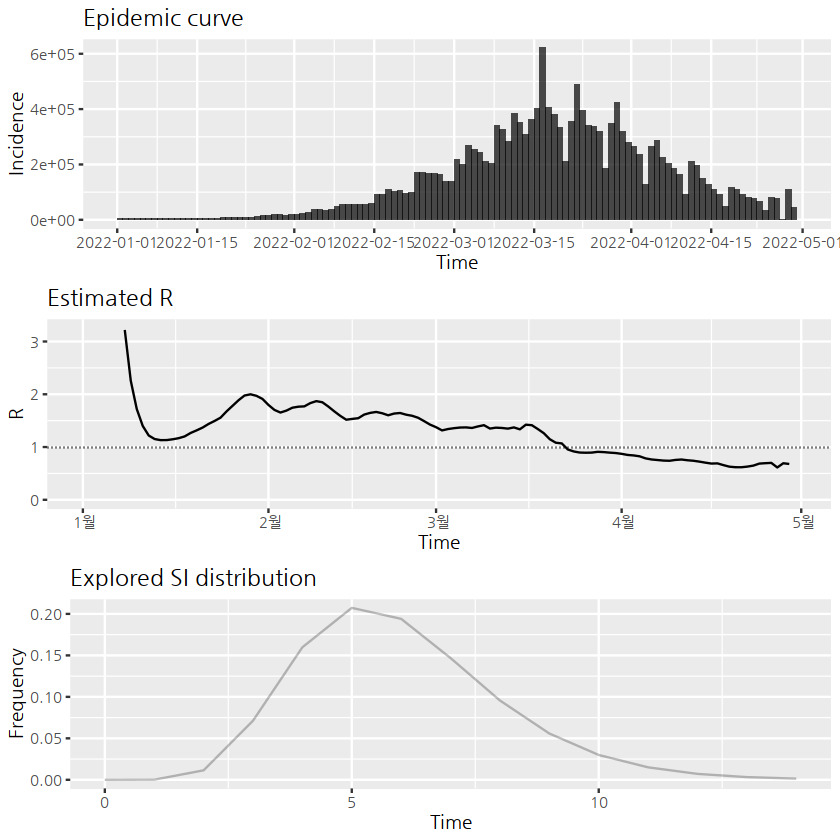

In [1]:
library(EpiEstim)
library(ggplot2)
library(tidyverse)
require(data.table)
require(deSolve)
library(gridExtra)
library(gridGraphics)
require(ggplot2)
library(dplyr)
library(lubridate)
require("sfsmisc")
library(scales)
library(gcookbook)
library(readxl)
library(readr)
# library(summarytools)
library(incidence)
library(tidyr)

# setwd("D://My Drive//2021_Korea SIR//Data")

lastdate<-545 ## by 2023

######################################Incidence data#################################################################
df_new<-read.csv("../../../../01_data/SEIR/owid-covid-data_0509.csv")

df<-df_new
df1<-df[c("date","location","new_cases","new_deaths", "new_tests", "people_vaccinated","people_fully_vaccinated")]
colnames(df1)[2]<-"state"
colnames(df1)[3]<-"cases"
colnames(df1)[4]<-"deaths"
df1$date =as.Date(df1$date, format="%Y-%m-%d")

df_kr<-df1%>% filter(state=="South Korea")
df_kr1<-df_kr[df_kr$date>="2022-01-01" & df_kr$date <"2022-04-30",]

cases<-df_kr1[c(1,3)]
colnames(cases)[2]<-"I"
colnames(cases)[1]<-"dates"

EL <- rep(0, times = 16)
ER <- rep(1, times = 16)
SL <- c(4,3,2,2,2,2,4,4,3,4,5,4,8,3,5,4)-1
SR <- c(8,4,4,5,9,4,6,5,4,5,6,5,9, 4,6,5)-1
type <- rep(0, times = 16)
df<-data.frame(EL, ER, SL, SR, type)

si<-c(0.05, 0.12, 0.18, 0.17, 0.16, 0.08, 0.05, 0.11, 0.04, 0.02, 0.01, 0.01)

Covid2021<-list("incidence" = cases, "si_distr" =si, "si_data" = df )
# head(Covid2021$incidence)
# Covid2021$si_distr
# head(Covid2021$si_data)


# plot(as.incidence(Covid2021$incidence$I, dates = Covid2021$incidence$dates))
# 
 incidence<-as.data.frame(Covid2021$incidence)
 incidence$dates =as.Date(incidence$dates, format="%Y-%m-%d")
 incidence1<-subset(incidence, dates >= "2022-01-01")
 incidence1$time <- 1:nrow(incidence1)


 
##Estimating R on sliding weekly windows, with a parametric serial interval
res_parametric_si <- estimate_R(Covid2021$incidence, 
                                method="parametric_si",
                                config = make_config(list(
                                  mean_si = 6, 
                                  std_si = 2))
)

#head(res_parametric_si$R)
plot(res_parametric_si, legend = FALSE)

Rt<-as.data.frame(res_parametric_si$R)
colnames(Rt)[3]<-"average_Rt"
Rt1<-subset(Rt, Rt$t_start > 24)
Rt1$time <- 1:nrow(Rt1)
aver_Rt<-mean(Rt1$average_Rt)
beta<-Rt1$average_Rt/14
#plot(aver_Rt)

# min(Rt)
# max(Rt)
# summary(Rt$average_Rt)
# 
# plot(df_kr$date, df_kr$new_tests)

######################################vaccination & variants data#################################################################
read_csv("../../../../01_data/SEIR/vaxx_1123_1.csv")->vac_prop


colnames(vac_prop) <-  c("time",    "age",    "dose",    "date",    "pfizer",    "JJ",    "moderna",    "AZ",    "AZPF")
vac_prop$age1 = ifelse(grepl("17", vac_prop$age), "1",
                       ifelse( grepl("18-19", vac_prop$age),"1",
                               ifelse(grepl("20-29", vac_prop$age),"2",
                               ifelse(grepl("30-39", vac_prop$age), "2",
                                      ifelse(grepl("40-49", vac_prop$age), "3",
                                             ifelse( grepl("50-59", vac_prop$age),"3",
                                                     ifelse(  grepl("60-64", vac_prop$age), "4",
                                                              ifelse(grepl("65-69", vac_prop$age), "4",
                                                                     ifelse( grepl("70-74", vac_prop$age), "4",
                                                                             ifelse(grepl("75-79", vac_prop$age), "4",
                                                                                    ifelse(grepl("80", vac_prop$age), "4",
                                                                                           NA))))))))))) ##case_when



vac_prop$date =as.Date(vac_prop$date , format="%m/%d/%Y")
popsize<-c(8907071, 13796133, 16695543, 11870436) ##0-19; 20-39; 40-59; 60+


vac_prop <- vac_prop %>% dplyr::select("time",    "age1",    "dose",    "date",    "pfizer",    "JJ",    "moderna",    "AZ",    "AZPF") %>%
        mutate(mRNA = pfizer + moderna) %>%
        mutate(week = strftime(date, "%V")) 

vac_prop <- vac_prop %>%
        dplyr::select(week, date, age1, dose, mRNA, AZ, JJ, AZPF) %>%
        mutate(dose = case_when (dose == 1 ~ c("dose1"),dose == 2 ~ c("dose2"), dose == 3 ~ c("dose3")))

# variants<-read_excel("variants_1123_3.xlsx") ##old data
variants<-read_excel("../../../../11_data/SEIR/variants_1005_1.xlsx") ##old data


variants1 <- variants[c(4, 8, 16)]
colnames(variants1) <- c("age",  "date", "virus")
# freq(variants1$virus)
# summary(variants1$date)

vac_prop$date<-as.Date(vac_prop$date)
variants1$date<-as.Date(variants1$date)

variants2<-variants1 %>% filter(date > "2021-03-05" & date < "2021-11-20") %>%
        #filter(!is.na(virus)) %>% filter(virus!=c("분석불가")) %>% 
        mutate(virus=case_when(virus==c("-") ~ c("Wild_type"),virus == NA ~ c("Wild_type"),
                               virus==c("alpha") ~ c("alpha"),
                               virus==c("delta") ~ c("delta"),
                               TRUE ~ c("etc"))) 

a<-data.frame(unclass(table(variants2$date,variants2$virus)))
a$Wild_type.true<-round(a$Wild_type*0.3) #70% are missing testing data (to be confirmed)
a$total<-rowSums(a[, c(1:4)])
#a$total<-colSums(a)
a$Delta.p<-round(a$delta/a$total,2)

aa <- cbind(rownames(a), data.frame(a, row.names=NULL))
names(aa)[1]<-"date"
aa$date<-as.Date(aa$date)
aaa<-aa %>% dplyr ::select(date, Delta.p)  
aaa$week= strftime(aaa$date, "%V")

aaa1<-aaa%>% 
        group_by(week)  %>%
        summarize(Delta.wp=max(Delta.p))

vac_prop1<-merge(vac_prop, aaa1, by=c("week"), all.x=TRUE)

ve_AZ1=0.5; ve_AZ2=0.77; ve_AZ3=0.8; ve_AZ1_delta=0.3; ve_AZ2_delta =0.66; ve_AZ3_delta=0.7
ve_JJ = 0.5; ve_JJ_delta = 0.3; 

ve_mRNA1 = 0.5; ve_mRNA2=0.95; ve_mRNA3=0.98
ve_mRNA1_delta=0.35; ve_mRNA2_delta=0.88; ve_mRNA3_delta=0.9

ve_mRNA_v <- c(ve_mRNA1, ve_mRNA2, ve_mRNA3)
ve_mRNA_delta_v<- c(ve_mRNA1_delta, ve_mRNA2_delta, ve_mRNA3_delta)

ve_AZ_v <- c(ve_AZ1, ve_AZ2, ve_AZ3)
ve_AZ_delta_v<- c(ve_AZ1_delta, ve_AZ2_delta, ve_AZ3_delta)

ve_JJ_v <- c(ve_JJ)
ve_JJ_delta_v<- c(ve_JJ_delta)

vac_prop3<-vac_prop1 %>%  
        ungroup()%>%
        mutate(age1=as.numeric(age1))%>%
        mutate(week=as.numeric(week))%>%
        mutate(totalpop=popsize[age1])%>%
        group_by(week, dose, age1) %>% 
        summarise (mRNA_p = sum (mRNA), AZ_p =sum(AZ), JJ_p=sum(JJ), AZPF_p=sum(AZPF), Delta.wp = first(Delta.wp), .groups="drop") %>%
        mutate(dose=factor(dose)) %>%
        mutate(ve_mRNA_w=(ve_mRNA_v[dose]*(1-Delta.wp)+ve_mRNA_delta_v[dose]*Delta.wp),
               mRNA_result = mRNA_p * ve_mRNA_w)%>%
        mutate(ve_AZ_w=(ve_AZ_v[dose]*(1-Delta.wp)+ve_AZ_delta_v[dose]*Delta.wp),
               AZ_result = AZ_p * ve_AZ_w)%>%
        mutate(ve_JJ_w=(ve_JJ_v*(1-Delta.wp)+ve_JJ_delta_v*Delta.wp),
               JJ_result = JJ_p * ve_JJ_w)%>%
        mutate(ve_AZPF_w=(ve_AZ_v[dose]*(1-Delta.wp)+ve_mRNA_delta_v[dose]*Delta.wp),
               AZPF_result = AZPF_p * ve_AZPF_w)

vac_prop4 <- vac_prop3 %>% 
        group_by(week, age1) %>%
        summarise (mRNA_p=sum(mRNA_p),
                   AZ_p=sum(AZ_p),
                   JJ_p=sum(JJ_p),
                   AZPF_p=sum(AZPF_p),
                   ve_mRNA_w = sum(ve_mRNA_w),
                   ve_AZ_w = sum(ve_AZ_w),
                   ve_JJ_w = sum(ve_JJ_w),
                   ve_AZPF_w = sum(ve_AZPF_w),
                   mRNA_result=sum(mRNA_result),
                   AZ_result=sum(AZ_result),
                   JJ_result=sum(JJ_result),
                   AZPF_result=sum(AZPF_result),
                   .groups="drop") %>%
        mutate(tot_result = rowSums(.[11:14])) 

vac_prop5 <- vac_prop4 %>% dplyr ::select(week, age1, tot_result)
vac_prop6<- round(spread(vac_prop5, key=week, value=tot_result))
vac_prop6 <- vac_prop6[,-1 ] 


##vac uptake from July-Oct first week
vac_prop7<-subset(vac_prop6[, c(18:38)])

vac_prop8<-vac_prop7/7  ## divide by 7 in order to convert to daily vaccination number

vac_prop8<-as.data.frame(vac_prop8,use.names=FALSE)
vac_prop8<-as.matrix(vac_prop8)
colnames(vac_prop8)<- NULL

aa1<-as.vector(vac_prop8[1,1:21])
aa2<-as.vector(vac_prop8[2,1:21])
aa3<-as.vector(vac_prop8[3,1:21])
aa4<-as.vector(vac_prop8[4,1:21])

age.vac<-matrix(NA, nrow=4, ncol=280) #30*7

for(i in 0:29){
        age.vac[1,(i*7+1):(i*7+7)]<-rep(aa1[i+1], each =7)
        age.vac[2,(i*7+1):(i*7+7)]<-rep(aa2[i+1], each =7)
        age.vac[3,(i*7+1):(i*7+7)]<-rep(aa3[i+1], each =7)
        age.vac[4,(i*7+1):(i*7+7)]<-rep(aa4[i+1], each =7)
}

age.vac[is.na(age.vac)] <- 0

age.vac1<-matrix(NA, nrow=4, ncol=lastdate)
age.vac1[1,]<-round(mean(age.vac[1,1:200]))
age.vac1[2,]<-round(mean(age.vac[2,1:200]))
age.vac1[3,]<-round(mean(age.vac[3,1:200]))
age.vac1[4,]<-round(mean(age.vac[4,1:200]))


sir_CEA_ud2 <- function(t,X,parms){
  # 
  # for (i in 1:length(X)) {
  #   if (X[i]< 0) {
  #     X[i]<- 0
  #   }}
  
  ncompartment=20
  nage=length(X)/ncompartment
  
  U =(X[1:nage])
  V =(X[(nage+1):(2*nage)])
  E =(X[(2*nage+1):(3*nage)])
  A =(X[(3*nage+1):(4*nage)])
  TP_ud=(X[(4*nage+1):(5*nage)])
  TP_noud=(X[(5*nage+1):(6*nage)])
  S_ud =(X[(6*nage+1):(7*nage)])
  S_noud = (X[(7*nage+1):(8*nage)])
  H_ud =(X[(8*nage+1):(9*nage)])
  H_noud = (X[(9*nage+1):(10*nage)])
  R_ud =(X[(10*nage+1):(11*nage)])
  R_noud = (X[(11*nage+1):(12*nage)])
  D_ud =(X[(12*nage+1):(13*nage)])
  D_noud = (X[(13*nage+1):(14*nage)])
  TP_ud.I =(X[(14*nage+1):(15*nage)])
  TP_noud.I =(X[(15*nage+1):(16*nage)])
  S.I_ud =(X[(16*nage+1):(17*nage)])
  S.I_noud= (X[(17*nage+1):(18*nage)])
  H.I_ud=(X[(18*nage+1):(19*nage)])
  H.I_noud= (X[(19*nage+1):(20*nage)])
  
  with(as.list(c(parms, X)), {
    
    # if (t==1){
    #   print(testing)
    #   print(vaccinating)
    # }
    # 
    # for (i in 1:length(X)) {
    #   if (X[i]< 0) {
    #     X[i]<- 0
    #   }}
    
    vaccination <- matrix(vac1(t, U, age.vac1), nrow=4, ncol=lastdate, byrow=F)
    #waining1 <- parms$wan*(V)
    waining2 <- parms$wan*(R_ud)
    waining3 <- parms$wan*(R_noud)
    #vaccination <- matrix(vac1(t), nrow=4, ncol=lastdate, byrow=T)*U
    infection1 <- matrix(contactpattern(t, aver_Rt), nrow=4, ncol=lastdate, byrow=T)* as.vector(((U*(C))%*%(A/(U+A+V+E))))
    infection2 <- matrix(contactpattern(t, aver_Rt), nrow=4, ncol=lastdate, byrow=T)* as.vector((V)*(A/(U+A+V+E)))
    #infection2 <- matrix(contactpattern(t, aver_Rt), nrow=4, ncol=lastdate, byrow=T)* as.vector((V*(C))%*%(A/(U+A+V+E)))
    incubation <- parms$theta*(E)
    testingrate <- matrix(tau2_1(t, tau2), nrow=4, ncol=lastdate, byrow=T)*Se*A
    screeningrate <- parms$tau1*(1-Sp)*(U)
    
    progression1 <-parms$sigma*(A)
    
    progression2 <-parms$sigma*(TP_ud)
    progression3 <-parms$sigma*(TP_noud)
    
    recovery1_ud <-parms$rho*(S_ud)
    recovery1_noud <-parms$rho*(S_noud)
    
    recovery2 <-parms$rho*(A)
    recovery3_ud <-parms$rho*(TP_ud)
    recovery3_noud <-parms$rho*(TP_noud)
    
    recovery4_ud <-parms$rho_h*(1-parms$delta )*H_ud
    recovery4_noud <-parms$rho_h*(1-parms$delta )*H_noud
    
    dead_ud <-parms$delta *(H_ud)
    dead_noud <-parms$delta *(H_noud)
    
    hospitalization_ud<-parms$adm_ud*S_ud
    hospitalization_noud<-parms$adm_noud*S_noud
    
    dUdt <- -infection1 - vaccination  +waining2 +waining3 #+waining1
    dVdt <- vaccination  - infection2 #-waining1
    dEdt <- infection1 - incubation + infection2
    dAdt <- incubation - testingrate - progression1 - recovery2
    dTP_uddt<- testingrate - recovery3_ud - progression2
    dTP_nouddt<- testingrate - recovery3_noud - progression3
    
    dS_uddt <- progression2 + progression1 - recovery1_ud - hospitalization_ud 
    dS_nouddt <- progression3 + progression1 - recovery1_noud - hospitalization_noud 
    
    dH_uddt <- hospitalization_ud - recovery4_ud - dead_ud
    dH_nouddt <- hospitalization_noud - recovery4_noud - dead_noud
    
    dR_uddt <- recovery1_ud+recovery2+recovery3_ud+recovery4_ud-waining2
    dR_nouddt <- recovery1_noud+recovery2+recovery3_noud+recovery4_noud-waining3
    
    dD_uddt <- dead_ud
    dD_nouddt <- dead_noud
    
    dTP_ud.Idt<- testingrate 
    dTP_noud.Idt<- testingrate 
    
    dS.I_uddt<- progression2 + progression1
    dS.I_nouddt<- progression3 + progression1
    
    dH.I_uddt<-hospitalization_ud
    dH.I_nouddt<-hospitalization_noud
    
    SEIR <- rbind(dUdt, dVdt, dEdt, dAdt, dTP_uddt,dTP_nouddt,dS_uddt,dS_nouddt, dH_uddt, dH_nouddt, dR_uddt,dR_nouddt, dD_uddt,dD_nouddt, dTP_ud.Idt,  dTP_noud.Idt, 
                  dS.I_uddt, dS.I_nouddt, dH.I_uddt, dH.I_nouddt)
    SEIR=as.data.frame(SEIR)
    
  })
}


## input param


############################### Rt, Testing, vaccination time functions ##########################################################
t <- seq(1, lastdate, by=1) 

vr=0.5 #by vaccination rate: 0.8,1
vac1 <- function(t, U, age.vac1) {
  res <- (t >= 1 & t < 142) * age.vac1  +
    (t >= 142 & t < 180) * age.vac1*c(3,0.5,0.5,0.1) *vr+  ## by Dec 2021
    (t >= 180 & t < 360) * age.vac1*c(2,0.3,0.2,0.01) *vr + #0.25  ## by Jun 2022
    (t >= 360 & t < 540) *age.vac1*c(0,0,0,0) *vr ##0.1  ## by Dec 2022
  return(pmin(res, U))
}


test<-df_kr[c("date","new_tests")]
test1<-subset(test, test$date >= "2022-01-01")
aver_test<-mean(test1$new_tests, na.rm=TRUE)
tau2<-aver_test/5000000 ## assumed total asymptomatic population

tr=1 #by test rate: 1,0.8,1.2
tau2_1 <- function(t, tau2) (t >= 1 & t < 142) * mean(tau2) +
  (t >= 142 & t < lastdate) * mean(tau2)*tr

##transimissibility
contact=1
transimissibility=aver_Rt*1/14*(1/contact)
npi=0.5 #0.5 0.6 0.7
npi_d=150+90 ##NPI by Feb, Apr, and Jun 2022 210 240 270


contactpattern <- function(t, aver_Rt) (t >= 1 & t < 200) * aver_Rt*1/14*(1/contact)*2 + ##Rt1.1
  (t >= 200 & t < 300) * aver_Rt*1/14*(1/contact)*7 +
  (t >= 300 & t  < lastdate) * aver_Rt*1/14*(1/contact)*1 ##Transmiss ##Transmissibility increase 2/2.2/2.4


########################################Initial conditions ######################################################################
npop <- 51822000
f <- c(0.17, 0.27, 0.33, 0.23) # four age classes, with 0-19; 20-39; 40-59; 60+ in Korea 2021
nage <-  length(f)
N <-  npop*f      # number in each age class


Se<- 0.95   #sensitivity
Sp<-0.998
mu = c(0, 0, 0,0) # screening return per day
tau1 = c(0, 0, 0,0)
#tau2= c(0.01, 0.01 , 0.01)*1 # testing per day (0.3)/(1-(0.3))*sigma :: assuming 30% testing among asymptomatic pop
#beta = c(0.1, 0.12, 0.13)*1 # infectious contacts per capita per day
theta = c(0.35, 0.35, 0.35, 0.35)  # incubation per day
sigma = c(0.14, 0.2, 0.15, 0.12)
#sigma = c(0.00025, 0.0058, 0.029, 0.19) # progression per day
rho = c(1/14, 1/14, 1/14, 1/14) 
rho_h = c(1/14, 1/14, 1/14, 1/14) # recovery per day
delta = c(0.00004, 0.0001, 0.00098, 0.047)  # case fatality among symptomatic patients per day
#vac = c(0, 0.03, 0.031)*1 ## July 0.03
eff<-1
adm_ud=c(0.00002,0.00152,0.00739,0.07959)*c(1, eff, eff, eff)
adm_noud=c(0.00002,0.00152,0.00739,0.07959)*c(1, 1, 1, 1) ## 0.7 as mol and 0.16 as pax
wan=c(0,0.0001,0.0001,0.0001)

# adm_ud=c(0.00025,0.0058,0.029,0.19)*0.2*c(1, eff, eff, eff)
# adm_noud=c(0.00025,0.0058,0.029,0.19)*0.2*c(1, eff, eff, eff) ## 0.7 as mol and 0.16 as pax
ud_p=c(0.3,0.3,0.3,0.3)

values <- list (mu = matrix(mu,nrow=4, ncol=lastdate ),
                tau1= matrix(tau1,nrow=4, ncol=lastdate ),
                theta= matrix(theta,nrow=4, ncol=lastdate ),
                sigma= matrix(sigma,nrow=4, ncol=lastdate),
                rho= matrix(rho,nrow=4, ncol=lastdate ),
                rho_h= matrix(rho_h,nrow=4, ncol=lastdate ),
                delta= matrix(delta,nrow=4, ncol=lastdate ),
                adm_ud=matrix(adm_ud,nrow=4, ncol=lastdate ),
                adm_noud=matrix(adm_noud,nrow=4, ncol=lastdate ),
                ud_p=matrix(ud_p,nrow=4, ncol=lastdate ),
                wan=matrix(wan,nrow=4, ncol=lastdate ),
                age.vac1=age.vac1,
                aver_Rt=aver_Rt,
                tau2=tau2  
                )

C = matrix(0,nrow=nage,ncol=nage)
C[1,1] = 2.3  # number contacts per day kids make with kids
C[1,2] = 0.6  
C[1,3] = 0.5  # number contacts per day kids make with adults (all kids have an adult in the home)
C[1,4] = 0.1 

C[2,1] = 0.7  # number contacts per day adults make with kids (not all adults have kids)
C[2,2] = 1.9
C[2,3] = 1.0
C[2,4] = 0.1

C[3,1] = 0.9  # number contacts per day adults make with kids (not all adults have kids)
C[3,2] = 1.2 
C[3,3] = 1.5  # number contacts per day adults make with adults
C[3,4] = 0.2 

C[4,1] = 0.3  # number contacts per day adults make with kids (not all adults have kids)
C[4,2] = 0.4 
C[4,3] = 0.5  # number contacts per day adults make with adults
C[4,4] = 0.4 


#install.packages("rootSolve")
#library(rootSolve)


##https://cran.r-project.org/web/packages/LaplacesDemon/index.html

V=c(724, 1257656, 1360168, 7290718) #by end of June cumulative vaccine uptake ( 724 1257656 1360168 7290718)
E=c(1000, 2000, 2000, 2000)
A=c(1000, 2000, 2000, 2000)
TP_ud=c(100, 200, 400, 300)*ud_p
TP_noud=c(100, 200, 400, 300)*(1-ud_p)
S_ud=c(0, 200, 400, 300)*ud_p
S_noud=c(200, 200, 400, 300)*(1-ud_p)
H_ud=c(2, 4, 8, 6)*ud_p
H_noud=c(2, 4, 8, 6)*(1-ud_p)
R_ud=c(50000,50000, 50000, 100000)*ud_p 
R_noud=c(50000,50000, 50000, 100000)*(1-ud_p) ## total confirmed cases 450,000 
D_ud=c(0, 0, 500, 1000)*ud_p
D_noud=c(0, 0, 500, 1000)*(1-ud_p)

TP_ud.I=c(100, 1000, 1000, 1000)*ud_p 
TP_noud.I=c(100, 1000, 1000, 1000)*(1-ud_p)
S.I_ud=c(100, 1000, 1000, 1000)*ud_p
S.I_noud=c(100, 1000, 1000, 1000)*(1-ud_p)
H.I_ud=c(2, 20, 20, 20)*ud_p
H.I_noud=c(2, 20, 20, 20)*(1-ud_p)
U = N-E-A-V-R_ud-R_noud

pop.SI <- c(U = N-E-A-V-R_ud-R_noud, V=V, E=E, A=A ,TP_ud=TP_ud, TP_noud=TP_noud, S_ud=S_ud, S_noud=S_noud, H_ud=H_ud, H_noud=H_noud,  R_ud=R_ud, R_noud=R_noud, 
            D_ud=D_ud, D_noud=D_noud,  TP_ud.I=TP_ud.I, TP_noud.I=TP_noud.I, S.I_ud=S.I_ud, S.I_noud=S.I_noud, H.I_ud=H.I_ud, H.I_noud=H.I_noud)


############################################ ODE simulation ###################################################################
result=lsoda(
  y = pop.SI,               # Initial conditions for population
  times = t,                # Timepoints for evaluation
  func = sir_CEA_ud2,           # Function to evaluate
  parms = values            # Vector of parameters
  
)

result1<-result[,c(1:81)]
result2<-as.data.frame(result1)

result2$U<-result2$U1+result2$U2+result2$U3+result2$U4
result2$V<-result2$V1+result2$V2+result2$V3+result2$V4
result2$E<-result2$E1+result2$E2+result2$E3+result2$E4
result2$A<-result2$A1+result2$A2+result2$A3+result2$A4
result2$TP_ud<-result2$TP_ud1+result2$TP_ud2+result2$TP_ud3+result2$TP_ud4
result2$TP_noud<-result2$TP_noud1+result2$TP_noud2+result2$TP_noud3+result2$TP_noud4

result2$TP<-result2$TP_ud+result2$TP_noud

result2$S_ud<-result2$S_ud1+result2$S_ud2+result2$S_ud3+result2$S_ud4
result2$S_noud<-result2$S_noud1+result2$S_noud2+result2$S_noud3+result2$S_noud4

result2$S<-result2$S_ud+result2$S_noud

result2$H_ud<-result2$H_ud1+result2$H_ud2+result2$H_ud3+result2$H_ud4
result2$H_noud<-result2$H_noud1+result2$H_noud2+result2$H_noud3+result2$H_noud4

result2$H<-result2$H_ud+result2$H_noud

result2$R_ud<-result2$R_ud1+result2$R_ud2+result2$R_ud3+result2$R_ud4
result2$R_noud<-result2$R_noud1+result2$R_noud2+result2$R_noud3+result2$R_noud4

result2$D_ud<-result2$D_ud1+result2$D_ud2+result2$D_ud3+result2$D_ud4
result2$D_noud<-result2$D_noud1+result2$D_noud2+result2$D_noud3+result2$D_noud4

result2$TP_ud.I<-result2$TP_ud.I1+result2$TP_ud.I2+result2$TP_ud.I3+result2$TP_ud.I4
result2$TP_noud.I<-result2$TP_noud.I1+result2$TP_noud.I2+result2$TP_noud.I3+result2$TP_noud.I4

result2$TP.I<-result2$TP_ud.I+result2$TP_noud.I

result2$S.I_ud<-result2$S.I_ud1+result2$S.I_ud2+result2$S.I_ud3+result2$S.I_ud4

#result2$S.I_ud<-result2$S.I_ud2+result2$S.I_ud3+result2$S.I_ud4
result2$S.I_noud<-result2$S.I_noud1+result2$S.I_noud2+result2$S.I_noud3+result2$S.I_noud4

result2$S.I<-result2$S.I_ud+result2$S.I_noud

result2$H.I_ud<-result2$H.I_ud1+result2$H.I_ud2+result2$H.I_ud3+result2$H.I_ud4
result2$H.I_noud<-result2$H.I_noud1+result2$H.I_noud2+result2$H.I_noud3+result2$H.I_noud4
result2$H.I<-result2$H.I_ud+result2$H.I_noud

result2$TP_ud1.incidence <- c(100*0.3,diff(result2$TP_ud.I1))
result2$TP_ud2.incidence <- c(200*0.3,diff(result2$TP_ud.I2))
result2$TP_ud3.incidence <- c(400*0.3,diff(result2$TP_ud.I3))
result2$TP_ud4.incidence <- c(300*0.3,diff(result2$TP_ud.I4))
result2$TP_ud.incidence <- c(1000*0.3,diff(result2$TP_ud.I))

result2$TP_noud1.incidence <- c(100*0.7,diff(result2$TP_noud.I1))
result2$TP_noud2.incidence <- c(200*0.7,diff(result2$TP_noud.I2))
result2$TP_noud3.incidence <- c(400*0.7,diff(result2$TP_noud.I3))
result2$TP_noud4.incidence <- c(300*0.7,diff(result2$TP_noud.I4))
result2$TP_noud.incidence <- c(1000*0.7,diff(result2$TP_noud.I))

result2$TP.incidence<-result2$TP_ud.incidence+result2$TP_noud.incidence

result2$S_ud1.incidence <- c(100*0.3,diff(result2$S.I_ud1))
result2$S_ud2.incidence <- c(200*0.3,diff(result2$S.I_ud2))
result2$S_ud3.incidence <- c(400*0.3,diff(result2$S.I_ud3))
result2$S_ud4.incidence <- c(300*0.3,diff(result2$S.I_ud4))
result2$S_ud.incidence <- c(1000*0.3,diff(result2$S.I_ud))

result2$S_noud1.incidence <- c(100*0.7,diff(result2$S.I_noud1))
result2$S_noud2.incidence <- c(200*0.7,diff(result2$S.I_noud2))
result2$S_noud3.incidence <- c(400*0.7,diff(result2$S.I_noud3))
result2$S_noud4.incidence <- c(300*0.7,diff(result2$S.I_noud4))
result2$S_noud.incidence <- c(1000*0.7,diff(result2$S.I_noud))

result2$S.incidence<-result2$S_ud.incidence +result2$S_noud.incidence 
result2$S_adult.incidence<-result2$S_ud2.incidence+result2$S_ud3.incidence+result2$S_ud4.incidence+result2$S_noud2.incidence+result2$S_noud3.incidence+result2$S_noud4.incidence

result2$H_ud1.incidence <- c(2*0.3,diff(result2$H.I_ud1))
result2$H_ud2.incidence <- c(4*0.3,diff(result2$H.I_ud2))
result2$H_ud3.incidence <- c(8*0.3,diff(result2$H.I_ud3))
result2$H_ud4.incidence <- c(6*0.3,diff(result2$H.I_ud4))
result2$H_ud.incidence <- c(20*0.3,diff(result2$H.I_ud))

result2$H_noud1.incidence <- c(2*0.7,diff(result2$H.I_noud1))
result2$H_noud2.incidence <- c(4*0.7,diff(result2$H.I_noud2))
result2$H_noud3.incidence <- c(8*0.7,diff(result2$H.I_noud3))
result2$H_noud4.incidence <- c(6*0.7,diff(result2$H.I_noud4))
result2$H_noud.incidence <- c(20*0.7,diff(result2$H.I_noud))

result2$H.incidence<-result2$H_ud.incidence+result2$H_noud.incidence

result2$V1.incidence <- c(724,diff(result2$V1))
result2$V2.incidence <- c(1257656,diff(result2$V2))
result2$V3.incidence <- c(1360168,diff(result2$V3))
result2$V4.incidence <- c(7290718,diff(result2$V4))
result2$V.incidence <- c(9909266,diff(result2$V))

result2$V1_cum<-cumsum(result2$V1.incidence)
result2$V2_cum<-cumsum(result2$V2.incidence)
result2$V3_cum<-cumsum(result2$V3.incidence)
result2$V4_cum<-cumsum(result2$V4.incidence)

result2$V_cum<-cumsum(result2$V.incidence)

# plot(q1$date, q1$V_cum/51000000)
# plot(cum_vac$date, cum_vac$people_vaccinated/51000000)

result2<-round(result2)


library(gridExtra)
library(gridGraphics)
require(ggplot2)
library(dplyr)
library(lubridate)
library(scales)

calender <- seq(ymd("2022-03-12"), ymd("2023-12-30"), by="day")

result3<-result2
q1 <- merge(incidence1, result3, by="time", all.y = TRUE, no.dups = TRUE)
#q1 <- cbind(result.lhs.ci, q1)
for (i in 50:lastdate){
  q1$dates[i] = calender[i-50+1]
}

result4<-result2
q2 <- merge(incidence1, result4, by="time", all.y = TRUE, no.dups = TRUE)
#q2 <- cbind(result.lhs.ci, q2)
for (i in 50:lastdate){
  q2$dates[i] = calender[i-50+1]
}

result5<-result2
q3 <- merge(incidence1, result5, by="time", all.y = TRUE, no.dups = TRUE)
#q3 <- cbind(result.lhs.ci, q3)
for (i in 50:lastdate){
  q3$dates[i] = calender[i-50+1]
}

#q2<-round(q1[,4:43])

res_parametric_si <- estimate_R(q2$TP.incidence, 
                                method="parametric_si",
                                config = make_config(list(
                                  mean_si = 6, 
                                  std_si = 2))
)

Rt_sim<-as.data.frame(res_parametric_si$R)

plot(q1$dates, q1$U)
plot(q1$dates, q1$R)
plot(q1$dates, q1$V)
plot(q1$dates, q1$E)
plot(q1$dates, q1$A)
plot(q1$dates, q1$TP)
plot(q1$dates, q1$S)



##Rt 0.39, 0.41, 0.43
plot1<-ggplot(q1) + 
  #geom_rect(data=q1, aes(xmin=dates[c(96)], xmax=dates[c(126)], ymin=0, ymax=6000), fill="light grey", alpha=0.02)+
  geom_point(aes(x = dates, y = I/1000), size = 1, color = "darkblue") +
  geom_line(aes(x = dates, y = I/1000), size = 0.5, color = "darkblue") +
  geom_line(aes(x = dates, y = TP.incidence/1000), size = 2, color="red", group = 1) + 
  #geom_ribbon(data = q1, aes(x = dates, ymin = low, ymax = high), fill="red", alpha = .1) +
  #geom_line(data=q2, aes(x = dates, y = TP.incidence/1000), size = 2, color = "#FF9999") +
  # geom_ribbon(data = q2, aes(x = dates, ymin = low, ymax = high), fill="red", alpha = .05) +
  #geom_line(data=q3, aes(x = dates, y = TP.incidence/1000), size = 2, color = "#CC0033") +
  #geom_ribbon(data = q3, aes(x = dates, ymin = low, ymax = high), fill="red", alpha = .15) + 
  
  geom_vline(aes(xintercept = as.numeric(dates[c(119)])), linetype = 2, color = 'black') +
  #geom_vline(aes(xintercept = as.numeric(dates[c(255)])), linetype = 2, color = 'red') +
  scale_y_continuous(breaks = seq(0,800,100), minor_breaks = seq(0,800,100), limits = c(0,800), expand = c(0, 0)) + ## scale_y_continuous(label=comma)
  ylab('Incidence of COVID-19 cases (in thousand)') +
  xlab('') +
  ggtitle('') +
  scale_x_date( limits = as.Date(c("2022-01-01", "2022-12-31")), breaks = as.Date( c( "2022-01-01",  "2022-04-01", "2022-07-01", "2022-10-01"
                                                                                      ) ),
                labels = c ("Jan-2022", "Apr-2022", "Jul-2022", "Oct-2022"),expand = c(0, 0)) +
  #theme_classic()+
  theme(axis.text.x = element_text(angle = 0, hjust = 0.5, vjust = 0.1, color = "black"),
        axis.text.y = element_text(color = "black"),
        panel.grid.major.x = element_blank(),
        panel.grid.major.y = element_blank(),
        panel.grid.minor = element_blank(),
        axis.line.x = element_line(color = "black"),
        axis.line.y = element_line(color = "black"),
        panel.background = element_rect(fill = "white"),
        # legend.key=element_blank(),
        # legend.title = element_blank(),
        text = element_text(size=12),
        panel.spacing = unit(2, "lines"))+
  scale_color_manual(values = c("#FF9999","red", "#CC0033"))

plot1 

##NPI base, 2 weeks, 4 weeks 
plot2<-ggplot(q1) + 
#  geom_rect(data=q1, aes(xmin=dates[c(96)], xmax=dates[c(300)], ymin=0, ymax=20000), fill="light grey", alpha=0.02)+
#  geom_rect(data=q1, aes(xmin=dates[c(96)], xmax=dates[c(300+30)], ymin=0, ymax=20000), fill="light grey", alpha=0.008)+
#  geom_rect(data=q1, aes(xmin=dates[c(96)], xmax=dates[c(300-30)], ymin=0, ymax=20000), fill="grey", alpha=0.5)+
  geom_point(aes(x = dates, y = I), size = 1.5, color = "darkblue") +
  geom_line(aes(x = dates, y = I), size = 1, color = "darkblue") +
  geom_line(aes(x = dates, y = TP.incidence), size = 2, color="blue", group = 1) + 
#  geom_ribbon(data = q1, aes(x = dates, ymin = low, ymax = high), fill="red", alpha = .1) +
  
  geom_line(data=q2, aes(x = dates, y = TP.incidence), size = 2, color = "light blue") +
#  geom_ribbon(data = q2, aes(x = dates, ymin = low, ymax = high), fill="red", alpha = .05) +
  
  geom_line(data=q3, aes(x = dates, y = TP.incidence), size = 2, color = "dark blue") +
  
#  geom_ribbon(data = q3, aes(x = dates, ymin = low, ymax = high), fill="red", alpha = .15) +
  
  geom_vline(aes(xintercept = as.numeric(dates[c(142)])), linetype = 2, color = 'red') +
  geom_vline(aes(xintercept = as.numeric(dates[c(240)])), linetype = 2, color = 'red') +
  scale_y_continuous(breaks = seq(0,16000,2000), minor_breaks = seq(0,16000,2000), limits = c(0, 16000), expand = c(0, 0)) + ## scale_y_continuous(label=comma)
  ylab('Incidence') +
  xlab('') +
  ggtitle('') +
  scale_x_date( limits = as.Date(c("2021-07-01", "2022-12-30")), breaks = as.Date( c( "2021-07-01",  "2021-10-01", 
                                                                                      "2022-01-01",  "2022-04-01",   
                                                                                      "2022-07-01",  "2022-10-01" ) ),
                labels = c ("Jul-2021",  "Oct-2021",   "Jan-2022",  "Apr-2022", "Jul-2022", "Oct-2022"),expand = c(0, 0)) +
  theme(axis.text.x = element_text(angle = 0, hjust = 0.5, vjust = 0.1,color = "black"),
        axis.text.y = element_text(color = "black"),
        panel.grid.major.x = element_blank(),
        panel.grid.major.y = element_blank(),
        panel.grid.minor = element_blank(),
        axis.line.x = element_line(color = "black"),
        axis.line.y = element_line(color = "black"),
        panel.background = element_rect(fill = "white"),
        legend.key=element_blank(),
        legend.title = element_blank(),
        text = element_text(size=12),
        panel.spacing = unit(2, "lines"))

plot2

library(zoo)
q2<-q1%>%select("dates", "TP.incidence")
q2$Yearmonth<-as.yearmon(q2$dates, "%Y-%m")

library(dplyr)
q3<-q2 %>% 
  group_by(Yearmonth) %>% 
  summarise(TP.incidence = sum(TP.incidence))

##Vaccine rate 0.7, 0.6, 0.8
plot3<-ggplot(q1) + 
  #  geom_rect(data=q1, aes(xmin=dates[c(96)], xmax=dates[c(126)], ymin=0, ymax=6000), fill="light grey", alpha=0.02)+
  geom_point(aes(x = dates, y = I), size = 1, color = "darkblue", fill = "white") +
  geom_line(aes(x = dates, y = I), size = 0.5, color = "darkblue", fill = "white") +
  #  geom_ribbon(data = q1, aes(x = dates, ymin = low, ymax = high), fill="red", alpha = .1) +
  
  geom_line(data=q2, aes(x = dates, y = TP.incidence), size = 2, color = "light blue", fill = "white") +
  geom_line(aes(x = dates, y = TP.incidence), size = 2, color="blue", group = 1) + 
  #  geom_ribbon(data = q2, aes(x = dates, ymin = low, ymax = high), fill="red", alpha = .05) +
  
  geom_line(data=q3, aes(x = dates, y = TP.incidence), size = 2, color = "dark blue", fill = "white") +
  geom_line(data=q4, aes(x = dates, y = TP.incidence), size = 2, color = "black") +
  #  geom_ribbon(data = q3, aes(x = dates, ymin = low, ymax = high),fill="red", alpha = .15) +
  
  geom_vline(aes(xintercept = as.numeric(dates[c(142)])), linetype = 2, color = 'black') +
  geom_vline(aes(xintercept = as.numeric(dates[c(240-30)])), linetype = 2, color = 'red') +
  geom_vline(aes(xintercept = as.numeric(dates[c(240)])), linetype = 2, color = 'red') +
  geom_vline(aes(xintercept = as.numeric(dates[c(240+30)])), linetype = 2, color = 'red') +
  scale_y_continuous(breaks = seq(0,16000,2000), minor_breaks = seq(0,16000,2000), limits = c(0, 16000), expand = c(0, 0)) + ## scale_y_continuous(label=comma)
  ylab('Incidence') +
  xlab('') +
  ggtitle('') +
  scale_x_date( limits = as.Date(c("2021-07-01", "2022-12-30")), breaks = as.Date( c( "2021-07-01",  "2021-10-01", 
                                                                                      "2022-01-01",  "2022-04-01",   
                                                                                      "2022-07-01",  "2022-10-01" ) ),
                labels = c ("Jul-2021",  "Oct-2021",   "Jan-2022",  "Apr-2022", "Jul-2022", "Oct-2022"),expand = c(0, 0)) +
  theme(axis.text.x = element_text(angle = 0, hjust = 0.5, vjust = 0.1,color = "black"),
        axis.text.y = element_text(color = "black"),
        panel.grid.major.x = element_blank(),
        panel.grid.major.y = element_blank(),
        panel.grid.minor = element_blank(),
        axis.line.x = element_line(color = "black"),
        axis.line.y = element_line(color = "black"),
        panel.background = element_rect(fill = "white"),
        legend.key=element_blank(),
        legend.title = element_blank(),
        text = element_text(size=12),
        panel.spacing = unit(2, "lines"))

plot3





##Vaccine rate 0.7, 0.6, 0.8
plot3<-ggplot(q1) + 
#  geom_rect(data=q1, aes(xmin=dates[c(96)], xmax=dates[c(126)], ymin=0, ymax=6000), fill="light grey", alpha=0.02)+
  geom_point(aes(x = dates, y = I), size = 1, color = "darkblue", fill = "white") +
  geom_line(aes(x = dates, y = I), size = 0.5, color = "darkblue", fill = "white") +
#  geom_ribbon(data = q1, aes(x = dates, ymin = low, ymax = high), fill="red", alpha = .1) +
  geom_line(aes(x = dates, y = TP.incidence), size = 2, color="red", group = 1) +   
  geom_line(data=q2, aes(x = dates, y = TP.incidence), size = 2, color = "#FF9999", fill = "white") +
  
#  geom_ribbon(data = q2, aes(x = dates, ymin = low, ymax = high), fill="red", alpha = .05) +
  
  geom_line(data=q3, aes(x = dates, y = TP.incidence), size = 2, color = "#CC0033", fill = "white") +
#  geom_line(data=q4, aes(x = dates, y = TP.incidence), size = 2, color = "black") +
#  geom_ribbon(data = q3, aes(x = dates, ymin = low, ymax = high),fill="red", alpha = .15) +
  
  geom_vline(aes(xintercept = as.numeric(dates[c(142)])), linetype = 2, color = 'black') +
  geom_vline(aes(xintercept = as.numeric(dates[c(240-30)])), linetype = 2, color = 'red') +
  geom_vline(aes(xintercept = as.numeric(dates[c(240)])), linetype = 2, color = 'red') +
  geom_vline(aes(xintercept = as.numeric(dates[c(240+30)])), linetype = 2, color = 'red') +
  scale_y_continuous(breaks = seq(0,16000,2000), minor_breaks = seq(0,16000,2000), limits = c(0, 16000), expand = c(0, 0)) + ## scale_y_continuous(label=comma)
  ylab('Incidence') +
  xlab('') +
  ggtitle('') +
  scale_x_date( limits = as.Date(c("2021-07-01", "2022-12-30")), breaks = as.Date( c( "2021-07-01",  "2021-10-01", 
                                                                                      "2022-01-01",  "2022-04-01",   
                                                                                      "2022-07-01",  "2022-10-01" ) ),
                labels = c ("Jul-2021",  "Oct-2021",   "Jan-2022",  "Apr-2022", "Jul-2022", "Oct-2022"),expand = c(0, 0)) +
  theme(axis.text.x = element_text(angle = 0, hjust = 0.5, vjust = 0.1,color = "black"),
        axis.text.y = element_text(color = "black"),
        panel.grid.major.x = element_blank(),
        panel.grid.major.y = element_blank(),
        panel.grid.minor = element_blank(),
        axis.line.x = element_line(color = "black"),
        axis.line.y = element_line(color = "black"),
        panel.background = element_rect(fill = "white"),
        legend.key=element_blank(),
        legend.title = element_blank(),
        text = element_text(size=12),
        panel.spacing = unit(2, "lines"))

plot3

##Test 0.36, 0.38, 0.4
plot4<-ggplot(q1) + 
  #geom_rect(data=q1, aes(xmin=dates[c(96)], xmax=dates[c(156)], ymin=0, ymax=6000), fill="light grey", alpha=0.02)+
  geom_point(aes(x = dates, y = I), size = 1.5, color = "darkblue") +
  geom_line(aes(x = dates, y = I), size = 1, color = "darkblue") +
  geom_line(aes(x = dates, y = TP.incidence), size = 2, color="red", group = 1) + 
#  geom_ribbon(data = q1, aes(x = dates, ymin = low, ymax = high), fill="red", alpha = .1) +
  
  geom_line(data=q2, aes(x = dates, y = TP.incidence), size = 2, color = "#FF9999") +
#  geom_ribbon(data = q2, aes(x = dates, ymin = low, ymax = high), fill="red", alpha = .05) +
  
  geom_line(data=q3, aes(x = dates, y = TP.incidence), size = 2, color = "#CC0033") +
#  geom_ribbon(data = q3, aes(x = dates, ymin = low, ymax = high), fill="red", alpha = .15) +
  
  geom_vline(aes(xintercept = as.numeric(dates[c(142)])), linetype = 2, color = 'red') +
  geom_vline(aes(xintercept = as.numeric(dates[c(240)])), linetype = 2, color = 'red') +
  scale_y_continuous(breaks = seq(0,20000,5000), minor_breaks = seq(0,20000,5000), limits = c(0, 20000), expand = c(0, 0)) + ## scale_y_continuous(label=comma)
  ylab('Incidence') +
  xlab('Date') +
  ggtitle('') +
  scale_x_date( limits = as.Date(c("2021-07-01", "2022-12-30")), breaks = as.Date( c( "2021-07-01",  "2021-10-01", 
                                                                                      "2022-01-01",  "2022-04-01",   
                                                                                      "2022-07-01",  "2022-10-01" ) ),
                labels = c ("Jul-2021",  "Oct-2021",   "Jan-2022",  "Apr-2022", "Jul-2022", "Oct-2022"),expand = c(0, 0)) +
  theme(axis.text.x = element_text(angle = 0, hjust = 0.5, vjust = 0.1, color = "black"),
        axis.text.y = element_text(color = "black"),
        panel.grid.major.x = element_blank(),
        panel.grid.major.y = element_blank(),
        panel.grid.minor = element_blank(),
        axis.line.x = element_line(color = "black"),
        axis.line.y = element_line(color = "black"),
        panel.background = element_rect(fill = "white"),
        legend.key=element_blank(),
        legend.title = element_blank(),
        text = element_text(size=12),
        panel.spacing = unit(2, "lines"))
  

plot4



library(ggpubr)
plot.all<-ggarrange(plot1, plot2, plot3, plot4,
                    ncol = 2, nrow = 2, common.legend = TRUE, legend = "bottom", #hjust=-2, #vjust=0.2,
                    labels = c("Rt(2.8/3.2/3.7) after April 2022", "NPI by Mar/Apr/May 2022", "Testing(-/+20%)", "Vaccination(68/72/75% by 2023)"),
                    font.label = list(size = 12, color = "dark blue"))+  theme(legend.title = element_text(size = 10, face = "bold"))

annotate_figure(plot.all,
                top = text_grob("Epidemic/Intervention scenarios", color = "black", face = "bold", size = 12),
                bottom = text_grob("", color = "black", hjust = 1, x = 1, face = "italic", size = 8),
                left = text_grob("", color = "black", rot = 90, size = 8),
                right = "",
                fig.lab = "Figure", fig.lab.face = "bold")


# plot.all<-ggarrange(plot1, plot2, plot3, plot4,
#                        ncol = 2, nrow = 2, common.legend = TRUE, legend = "bottom", #hjust=-2, #vjust=0.2,
#                        labels = c("Rt(1.13)/1m NPI/Testing(low/high)", "Rt(1.13)/2m NPI/Testing(low/high)", "Rt(1.2)/1m NPI/Testing(low/high)", "Rt(1.2)/2m NPI/Testing(low/high)"),
#                        font.label = list(size = 12, color = "dark blue"))+  theme(legend.title = element_text(size = 10, face = "bold"))
# 
# annotate_figure(plot.all,
#                 top = text_grob("Epidemic/Intervention scenarios", color = "black", face = "bold", size = 12),
#                 bottom = text_grob("", color = "black", hjust = 1, x = 1, face = "italic", size = 8),
#                 left = text_grob("", color = "black", rot = 90, size = 8),
#                 right = "",
#                 fig.lab = "Figure", fig.lab.face = "bold")

plot(0,type='n',axes=FALSE,ann=FALSE, xpd=T)
legend("top", title="Legend",
       c( "low testing value","testing base case","high testing value","confirmed case"), col=c("#FF9999","red", "#CC0033","dark blue"), 
       horiz=FALSE, cex=1.10, xpd=T, lwd=3, pch=c(NA, NA, NA, 16) )

plot(0,type='n',axes=FALSE,ann=FALSE, xpd=T)
legend("top", title="Age group",
       c( "Age 0-19","Age 20-39", "Age 40-59", "Age 60+"), col=c("dark green","blue", "red", "dark grey"), 
       horiz=FALSE, cex=1.10, xpd=T, lwd=3, pch=c(NA, NA, NA) )

legend(as.numeric(q1$dates[c(100)]),0.4,c("age 0-19","age 20-39", "age 40-59", "age 60+"), lwd=c(2,2), col=c("dark green","blue", "red", "dark grey"), y.intersp=1)


ggarrange(plot1,plot1,
          ncol = 2, nrow = 1)

plot(0,type='n',axes=FALSE,ann=FALSE, xpd=T)
legend("top", title="Legend",
       c( "Projected incidence (base case)", "Projected incidence (scenarios)","Confirmed case"), col=c("#FF9999","red", "dark blue"), 
       horiz=FALSE, cex=1.10, xpd=T, lwd=3, pch=c(NA, NA, NA, 16) )


plot(0,type='n',axes=FALSE,ann=FALSE, xpd=T)
legend("top", title="Legend",
       c( "Projected prevalence (base case)", "Projected prevalence (scenarios)","ICU capacity"), col=c("#FF9999","red", "light blue"), 
       horiz=FALSE, cex=1.10, xpd=T, lwd=3, pch=c(NA, NA, NA, 16) )



plot(0,type='n',axes=FALSE,ann=FALSE, xpd=T)
legend("top", title="Legend",
       c( "Number of hospitalized patients (status quo)", "Number of hospitalized patients (eff 30% with molnupiravir)","Number of hospitalized patients (eff 87% with nirmatrelvir/ritonavir )", 
       "Number of ICU patients (status quo)", "Number of ICU patients  (eff 30% with molnupiravir)","Number of ICU patients (eff 87% with nirmatrelvir/ritonavir)", "hospital capacity", "ICU capacity"), 
       col=c("red", "purple","blue","red", "purple","blue", "light blue", "blue"), 
       horiz=FALSE, cex=1.10, xpd=T, lwd=3, lty=c(1,1,1,3,3,3,2,2), pch=c(NA, NA, NA,NA, NA, NA, NA, NA))

plot(0,type='n',axes=FALSE,ann=FALSE, xpd=T)
legend("top", title="Legend",
       c( "U (1000)", "U (2000)","U (3000)","Confirmed case"), col=c("red","#FF9999","#CC0033", "dark blue"), 
       horiz=FALSE, cex=1.10, xpd=T, lwd=3, pch=c(NA, NA, NA, 16) )

plot(0,type='n',axes=FALSE,ann=FALSE, xpd=T)
legend("top", title="Legend",
       c( "E(10); A(1)", "E(50); A(5)","E(100); A(10)","Confirmed case"), col=c("red","#FF9999","#CC0033", "dark blue"), 
       horiz=FALSE, cex=1.10, xpd=T, lwd=3, pch=c(NA, NA, NA, 16) )

plot(0,type='n',axes=FALSE,ann=FALSE, xpd=T)
legend("top", title="Legend",
       c( "testing (base:0.05)", "testing (0.01)","testing (0.1)","Confirmed case"), col=c("red","#FF9999","#CC0033", "dark blue"), 
       horiz=FALSE, cex=1.10, xpd=T, lwd=3, pch=c(NA, NA, NA, 16) )


plot(0,type='n',axes=FALSE,ann=FALSE, xpd=T)
legend("top", title="Legend",
       c( "force of infection (base)", "force of infection (x0.5)","force of infection (x1.5)","Confirmed case"), col=c("red","#FF9999","#CC0033", "dark blue"), 
       horiz=FALSE, cex=1.10, xpd=T, lwd=3, pch=c(NA, NA, NA, 16) )

plot(0,type='n',axes=FALSE,ann=FALSE, xpd=T)
legend("top", title="Legend",
       c( "Testing (7/6, base)", "Testing (6/22, 8th day)","Testing (6/17, 3rd day)","Confirmed case"), col=c("red","#FF9999","#CC0033", "dark blue"), 
       horiz=FALSE, cex=1.10, xpd=T, lwd=3, pch=c(NA, NA, NA, 16) )

plot(0,type='n',axes=FALSE,ann=FALSE, xpd=T)
legend("top", title="Legend",
       c( "Testing (7/6, base)", "Testing (6/30, 1 wk before)","Testing (6/24, 2 wks before)","Confirmed case"), col=c("red","#FF9999","#CC0033", "dark blue"), 
       horiz=FALSE, cex=1.10, xpd=T, lwd=3, pch=c(NA, NA, NA, 16) )




plot(0,type='n',axes=FALSE,ann=FALSE, xpd=T)
legend("top", title="Legend",
       c( "force of infection (base)", "force of infection (x0.5)","force of infection (x1.5)"), col=c("red","#FF9999","#CC0033"), 
       horiz=FALSE, cex=1.10, xpd=T, lwd=3, pch=c(NA, NA, NA) )

plot(0,type='n',axes=FALSE,ann=FALSE, xpd=T)
legend("top", title="Legend",
       c( "E(10); A(1)", "E(50); A(5)","E(100); A(10)"), col=c("red","#FF9999","#CC0033"), 
       horiz=FALSE, cex=1.10, xpd=T, lwd=3, pch=c(NA, NA, NA) )

plot(0,type='n',axes=FALSE,ann=FALSE, xpd=T)
legend("top", title="Legend",
       c( "U (1000)", "U (2000)","U (3000)"), col=c("red","#FF9999","#CC0033"), 
       horiz=FALSE, cex=1.10, xpd=T, lwd=3, pch=c(NA, NA, NA) )

plot(0,type='n',axes=FALSE,ann=FALSE, xpd=T)
legend("top", title="Legend",
       c( "Testing(basex0.8)", "Testing(base)","Testing(basex1.2)"), col=c("#FF9999","red","#CC0033"), 
       horiz=FALSE, cex=1.10, xpd=T, lwd=3, pch=c(NA, NA, NA) )
